In [1]:
{
  "data": "[{\"EXT_SOURCE_2\":0.0304315707,\"EXT_SOURCE_3\":0.1107962886,\"CODE_GENDER\":0.7209239877,\"PAYMENT_RATE\":-0.2418253653,\"DAYS_EMPLOYED\":0.2833922874,\"PREV_CNT_PAYMENT_MEAN\":-0.2903476431,\"NAME_EDUCATION_TYPE_Highereducation\":1.7625702765,\"INSTAL_DPD_MEAN\":-0.052079095,\"DAYS_BIRTH\":-0.9914858035,\"AMT_ANNUITY\":0.6444642056}]"
}


{'data': '[{"EXT_SOURCE_2":0.0304315707,"EXT_SOURCE_3":0.1107962886,"CODE_GENDER":0.7209239877,"PAYMENT_RATE":-0.2418253653,"DAYS_EMPLOYED":0.2833922874,"PREV_CNT_PAYMENT_MEAN":-0.2903476431,"NAME_EDUCATION_TYPE_Highereducation":1.7625702765,"INSTAL_DPD_MEAN":-0.052079095,"DAYS_BIRTH":-0.9914858035,"AMT_ANNUITY":0.6444642056}]'}

In [ ]:
{
  "data2": "[{\"EXT_SOURCE_2\":0.0304315707,\"EXT_SOURCE_3\":0.1107962886,\"CODE_GENDER\":0.7209239877,\"PAYMENT_RATE\":-0.2418253653,\"DAYS_EMPLOYED\":-0.2833922874, \"INSTAL_DPD_MEAN\":-0.052079095,\"PREV_CNT_PAYMENT_MEAN\":-0.2903476431,\"NAME_EDUCATION_TYPE_Highereducation\":1.7625702765,\"DAYS_BIRTH\":0.9914858035,\"AMT_ANNUITY\":0.6444642056}]"
}


In [ ]:
{
  "data3": "[{\"EXT_SOURCE_2\":0.520273,\"EXT_SOURCE_3\":NaN,\"CODE_GENDER\":1,\"PAYMENT_RATE\":0.048278,\"DAYS_EMPLOYED\":NaN, \"INSTAL_DPD_MEAN\":0.533333,\"PREV_CNT_PAYMENT_MEAN\":12.000000,\"NAME_EDUCATION_TYPE_Highereducation\":1,\"DAYS_BIRTH\":55.80,\"AMT_ANNUITY\":36459.0}]"
}

In [ ]:
{
  "shap_values": [
    0.09736898981626704,
    0.09061391851391862,
    -0.14591837167325145,
    0.22317605221727396,
    -0.042213135891435015,
    0.0891552525846353,
    -0.07474000126492085,
    -0.26429819226154483,
    -0.13948427638357988,
    0.13659228933581974
  ],
  "base_value": -0.4876034355259544
}

In [66]:
{
  "shap_values": [
    0.9057239838209107,
    1.189427631108543,
    -0.009562847394119023,
    -1.164074249003706,
    -0.01968466929305565,
    -0.12401148423476481,
    -0.3174124294896501,
    -0.18924200401810343,
    -0.14040092533724738,
    -0.9088612107616951
  ],
  "base_value": -0.4876034355259544
}

{'shap_values': [0.9057239838209107,
  1.189427631108543,
  -0.009562847394119023,
  -1.164074249003706,
  -0.01968466929305565,
  -0.12401148423476481,
  -0.3174124294896501,
  -0.18924200401810343,
  -0.14040092533724738,
  -0.9088612107616951],
 'base_value': -0.4876034355259544}

In [1]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

# Importation des libraries

import sys
import functions
#from functions import *
import gc
import time
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from contextlib import contextmanager
import mlflow
import mlflow.sklearn
import shap
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, roc_auc_score, auc, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif # use this for classification tasks
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pwd

'/Users/zeyneperdem/Desktop/ds_prep/p7'

In [3]:
# Les versions des libraries
print("Python: ", sys.version)
print("Pandas: ", pd.__version__)
print("Numpy: ", np.__version__)
print("Seaborn: ", sns.__version__)
print("Matplotlib: ", matplotlib.__version__)
print("Missingno: ", msno.__version__)
print("Sklearn: ", sklearn.__version__)

Python:  3.9.17 (main, Jul  5 2023, 15:35:09) 
[Clang 14.0.6 ]
Pandas:  2.0.3
Numpy:  1.23.5
Seaborn:  0.12.2
Matplotlib:  3.7.2
Missingno:  0.4.2
Sklearn:  1.2.2


In [4]:
# Les options pour visualisations des dataframes
pd.set_option("display.max_columns", None)

## Importation des données

In [5]:
path = "/Users/zeyneperdem/Desktop/ds_prep/p7/"

In [6]:
dataset = pd.read_csv(path + "dataset.csv")
dataset.head(3)

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0            0             0                0   
1      100003     0.0            1             0                1   
2      100004     0.0            0             1                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461         -637.0            -3648.0   
1                    0.003541      -16765        -1188.0            -1186.0   
2                    0.010032      -19046         -225.0            -4260.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   
1                       0                        0      0.311267   
2                       0                        0           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262949      0.139376          0.0247            0.0369   
1      0.622246           NaN          0.0959            0.0529   
2      0.555912      0.729567             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960          0.0605   
2                          NaN              NaN             NaN   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0           0.00         0.0690         0.0833         0.1250        0.0369   
1           0.08         0.0345         0.2917         0.3333        0.0130   
2            NaN            NaN            NaN            NaN           NaN   

   LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
0                0.0202          0.0190                   0.0000   
1                0.0773          0.0549                   0.0039   
2                   NaN             NaN                      NaN   

   NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  \
0             0.0000           0.0252             0.0383   
1             0.0098           0.0924             0.0538   
2                NaN              NaN                NaN   

   YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  \

# On va changer les valeurs des colonnes Days birth et Days employed

In [7]:
dataset.DAYS_BIRTH = (dataset.DAYS_BIRTH / -365).round(2)
dataset.DAYS_EMPLOYED = (dataset.DAYS_EMPLOYED / -365).round(2)

In [8]:
dataset.head(2)

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0            0             0                0   
1      100003     0.0            1             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       25.92           1.75            -3648.0   
1                    0.003541       45.93           3.25            -1186.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   
1                       0                        0      0.311267   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262949      0.139376          0.0247            0.0369   
1      0.622246           NaN          0.0959            0.0529   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960          0.0605   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0           0.00         0.0690         0.0833         0.1250        0.0369   
1           0.08         0.0345         0.2917         0.3333        0.0130   

   LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
0                0.0202          0.0190                   0.0000   
1                0.0773          0.0549                   0.0039   

   NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  \
0             0.0000           0.0252             0.0383   
1             0.0098           0.0924             0.0538   

   YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  \
0                        0.9722            0.6341           0.0144   
1                        0.9851            0.8040           0.0497   

   ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  FLOORSMIN_MODE  \
0          0.0000          0.0690          0.0833          0.1250   
1          0.0806          0.0345          0.2917          0.3333   

   LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  \
0         0.0377                  0.022           0.0198   
1         0.0128                  0.079           0.0554   

   NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  \
0                       0.0                 0.0           0.0250   
1                       0.0                 0.0           0.0968   

   BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
0             0.0369                        0.9722            0.6243   
1             0.0529                        0.9851            0.7987   

   COMMONAREA_MEDI  ELEVATO

## Exploration Data Analyses pour le fichier "dataset"

In [9]:
functions.info_general(dataset)

************************* * INFORMATIONS GENERALES DE NOTRE DATAFRAME * *************************
----------------------------------------------------------------------------------------------------

Il y a 307507 lignes et 797 colonnes dans notre dataframe.
----------------------------------------------------------------------------------------------------
* On obtiens l'info sur notre dataframe * 
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 797 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(623), int64(174)
memory usage: 1.8 GB
None
----------------------------------------------------------------------------------------------------
* On obtient les informations statistiques sur notre dataframe * 
----------------------------------------------------------------------------------------------------


count           mean            std  \
SK_ID_CURR                        307507.0  278181.527256  102790.132982   
TARGET                            307507.0       0.080730       0.272420   
CODE_GENDER                       307507.0       0.658352       0.474263   
FLAG_OWN_CAR                      307507.0       0.340106       0.473745   
FLAG_OWN_REALTY                   307507.0       0.306331       0.460970   
...                                    ...            ...            ...   
CC_NAME_CONTRACT_STATUS_nan_MAX    86905.0       0.000000       0.000000   
CC_NAME_CONTRACT_STATUS_nan_MEAN   86905.0       0.000000       0.000000   
CC_NAME_CONTRACT_STATUS_nan_SUM    86905.0       0.000000       0.000000   
CC_NAME_CONTRACT_STATUS_nan_VAR    86273.0       0.000000       0.000000   
CC_COUNT                           86905.0      37.143605      33.698512   

                                       min       25%       50%       75%  \
SK_ID_CURR                        100002.0  189146.5  278203.0  367143.5   
TARGET                                 0.0       0.0       0.0       0.0   
CODE_GENDER                            0.0       0.0       1.0       1.0   
FLAG_OWN_CAR                           0.0       0.0       0.0       1.0   
FLAG_OWN_REALTY                        0.0       0.0       0.0       1.0   
...                                    ...       ...       ...       ...   
CC_NAME_CONTRACT_STATUS_nan_MAX        0.0       0.0       0.0       0.0   
CC_NAME_CONTRACT_STATUS_nan_MEAN       0.0       0.0       0.0       0.0   
CC_NAME_CONTRACT_STATUS_nan_SUM        0.0       0.0       0.0       0.0   
CC_NAME_CONTRACT_STATUS_nan_VAR        0.0       0.0       0.0       0.0   
CC_COUNT                               1.0      10.0      22.0      75.0   

                                       max  
SK_ID_CURR                        456255.0  
TARGET                                 1.0  
CODE_GENDER                            1.0  
FLAG_OWN_CAR                           1.0  
FLAG_OWN_REALTY                        1.0  
...                                    ...  
CC_NAME_CONTRACT_STATUS_nan_MAX        0.0  
CC_NAME_CONTRACT_STATUS_nan_MEAN       0.0  
CC_NAME_CONTRACT_STATUS_nan_SUM        0.0  
CC_NAME_CONTRACT_STATUS_nan_VAR        0.0  
CC_COUNT                             192.0  

[797 rows x 8 columns]

----------------------------------------------------------------------------------------------------
*On vérifie s'il y a des doublons dans notre dataframe* 
** Il n'y a pas de doublons **
----------------------------------------------------------------------------------------------------
** On vérifie s'il y a des valeurs nulles et on display pourcentage des valeurs nulles par colonne en descendant **
----------------------------------------------------------------------------------------------------
** On a  25.93 % de valeur nulle dans notre dataframe **


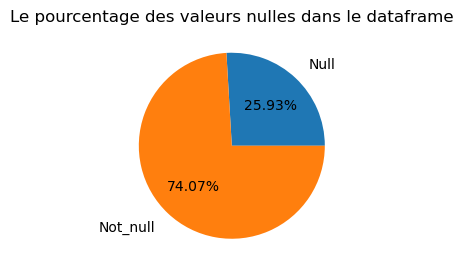

In [10]:
functions.graph_null(dataset)

In [11]:
df_null_dataset = functions.per_null_dataframe(dataset)
# Les colonnes incluent plus de 30% de valeurs manquantes
len(df_null_dataset[df_null_dataset["pourcentage_null"] >30])

253

In [12]:
# On va supprimer ces colonnes 
def remove_columns_with_high_nulls(df, threshold=30):
    """
    Remove columns from DataFrame that have more than a specified percentage of null values.
    
    :param df: DataFrame
    :param threshold: Percentage threshold for null values (default is 30)
    :return: DataFrame with specified columns removed
    """
    per_null = (df.isnull().mean() * 100).round(2)
    columns_to_remove = per_null[per_null > threshold].index
    df_cleaned = df.drop(columns=columns_to_remove)
    return df_cleaned

In [13]:
dataset_removed = remove_columns_with_high_nulls(dataset, threshold=30)
#dataset_removed = dataset_removed.drop("CODE_GENDER", axis=1)
dataset_removed.shape

(307507, 544)

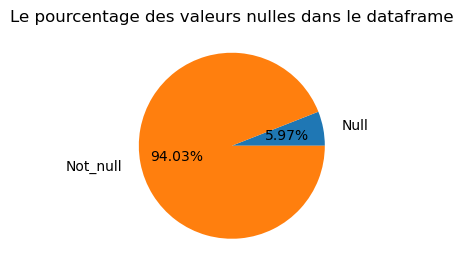

In [14]:
functions.graph_null(dataset_removed)

In [15]:
dataset_removed['TARGET'].isnull().sum()

0

In [16]:
dataset_indexed = dataset_removed.set_index('SK_ID_CURR')
dataset_indexed.head(2)

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
100002         1.0            0             0                0             0   
100003         0.0            1             0                1             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              202500.0    406597.5      24700.5         351000.0   
100003              270000.0   1293502.5      35698.5        1129500.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100002                        0.018801       25.92           1.75   
100003                        0.003541       45.93           3.25   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
SK_ID_CURR                                                                   
100002                -3648.0            -2120           1               1   
100003                -1186.0             -291           1               1   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
100002                    0                 1           1           0   
100003                    0                 1           1           0   

            CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                          
100002                  1.0                     2   
100003                  2.0                     1   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
100002                                2                       10   
100003                                1                       11   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
100002                               0                           0   
100003                               0                           0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
100002                                0                       0   
100003                                0                       0   

            REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
SK_ID_CURR                                                                  
100002                           0                        0      0.262949   
100003                           0                        0      0.622246   

            EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                                     
100002          0.139376                       2.0                       2.0   
100003               NaN                       1.0                       0.0   

            OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                       
100002                           2.0                       2.0   
100003                           1.0                       0.0   

            DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
100002                     -1134.0                0                1   
100003                      -828.0                0                1   

            FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                      
100002                    0                0                0   
100003                    0                0                0   

            FLAG_DOCUMENT_7  F

# Splitter notre dataset

### On va définir X et y

In [17]:
X = dataset_indexed.drop('TARGET', axis=1)
y = dataset_indexed['TARGET']

### Diviser les données en ensembles d'entraînement et de test

In [18]:
from sklearn.model_selection import train_test_split
X_train_null, X_test_null, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X_train_null = pd.DataFrame(X_train_null, columns=X.columns, index=X_train_null.index)
X_test_null = pd.DataFrame(X_test_null, columns=X.columns, index=X_test_null.index)
print(X_train_null.shape)
print(X_test_null.shape)

(246005, 542)
(61502, 542)


In [19]:
X_train_null.head(2)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
114418                0             0                1             0   
443851                1             0                1             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
114418              315000.0   1546020.0      45333.0        1350000.0   
443851               90000.0    180000.0       9000.0         180000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
114418                        0.046220       39.58           2.91   
443851                        0.018029       32.95           1.46   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
SK_ID_CURR                                                                   
114418                -4729.0            -4394           1               1   
443851                -3658.0            -2026           1               1   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
114418                    0                 1           0           0   
443851                    1                 1           0           0   

            CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                          
114418                  2.0                     1   
443851                  2.0                     3   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
114418                                1                       10   
443851                                3                        7   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
114418                               0                           0   
443851                               0                           0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
114418                                0                       0   
443851                                0                       0   

            REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
SK_ID_CURR                                                                  
114418                           0                        0      0.792495   
443851                           0                        0      0.556360   

            EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                                     
114418          0.497469                       0.0                       0.0   
443851               NaN                       0.0                       0.0   

            OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                       
114418                           0.0                       0.0   
443851                           0.0                       0.0   

            DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
114418                     -1658.0                0                1   
443851                      -559.0                0                0   

            FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                      
114418                    0                0                0   
443851                    0                0                0   

            FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9 

In [20]:
y_train.head(2)

SK_ID_CURR
114418    0.0
443851    0.0
Name: TARGET, dtype: float64

## On va imputer les valeurs manquantes avec médian de chaque colonne 

In [21]:
# On va remplacer les valeurs infinies par NaN avant de procéder à une imputation
X_train_null.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_null.replace([np.inf, -np.inf], np.nan, inplace=True)

In [22]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
X_train = imputer.fit_transform(X_train_null)
X_train = pd.DataFrame(X_train, columns=X_train_null.columns, index=X_train_null.index)
X_test = imputer.transform(X_test_null)
X_test = pd.DataFrame(X_test, columns=X_test_null.columns, index=X_test_null.index)

In [23]:
X_train.isnull().sum().sum()

0

In [24]:
X_train.describe()

CODE_GENDER   FLAG_OWN_CAR  FLAG_OWN_REALTY   CNT_CHILDREN  \
count  246005.000000  246005.000000    246005.000000  246005.000000   
mean        0.658011       0.339843         0.306762       0.416341   
std         0.474377       0.473657         0.461151       0.720894   
min         0.000000       0.000000         0.000000       0.000000   
25%         0.000000       0.000000         0.000000       0.000000   
50%         1.000000       0.000000         0.000000       0.000000   
75%         1.000000       1.000000         1.000000       1.000000   
max         1.000000       1.000000         1.000000      19.000000   

       AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count      2.460050e+05  2.460050e+05  246005.000000     2.460050e+05   
mean       1.688857e+05  5.993375e+05   27132.235282     5.385534e+05   
std        2.602985e+05  4.025214e+05   14472.153120     3.692027e+05   
min        2.565000e+04  4.500000e+04    1615.500000     4.500000e+04   
25%        1.125000e+05  2.700000e+05   16546.500000     2.385000e+05   
50%        1.485000e+05  5.147775e+05   24925.500000     4.500000e+05   
75%        2.025000e+05  8.086500e+05   34668.000000     6.795000e+05   
max        1.170000e+08  4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               246005.000000  246005.000000  246005.000000   
mean                     0.020861      43.939846       6.180004   
std                      0.013825      11.959264       5.871621   
min                      0.000290      20.520000      -0.000000   
25%                      0.010006      34.000000       2.560000   
50%                      0.018850      43.160000       4.520000   
75%                      0.028663      53.920000       7.560000   
max                      0.072508      69.120000      49.070000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
count      246005.000000    246005.000000    246005.0   246005.000000   
mean        -4987.424394     -2995.610650         1.0        0.820089   
std          3521.746270      1508.113045         0.0        0.384114   
min        -24672.000000     -7197.000000         1.0        0.000000   
25%         -7481.000000     -4299.000000         1.0        1.000000   
50%         -4504.000000     -3257.000000         1.0        1.000000   
75%         -2017.000000     -1723.000000         1.0        1.000000   
max             0.000000         0.000000         1.0        1.000000   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE     FLAG_EMAIL  \
count    246005.000000     246005.000000  246005.000000  246005.000000   
mean          0.199211          0.998098       0.280917       0.056820   
std           0.399408          0.043575       0.449448       0.231499   
min           0.000000          0.000000       0.000000       0.000000   
25%           0.000000          1.000000       0.000000       0.000000   
50%           0.000000          1.000000       0.000000       0.000000   
75%           0.000000          1.000000       1.000000       0.000000   
max           1.000000          1.000000       1.000000       1.000000   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count    246005.000000         246005.000000                246005.000000   
mean          2.151977              2.053133                     2.032312   
std           0.909717              0.509222                     0.502915   
min           1.000000              1.000000                     1.000000   
25%           2.000000              2.000000                     2.000000   
50%           2.000000              2.000000                     2.000000   
75%           3.000000              2.000000                     2.000000   
max          20.000000              3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count            246005.00

# Feature Selection

## Remove Low Variance Features

Sklearn provides the VarianceThreshold() function to remove less important features. It uses variance as the ranking criteria. We can use it to remove features that are constant (have a variance of 0, i.e. all rows have the same value) or nearly constant (have a variance that is very low).

In [25]:
# Perform feature selection using a variance threshold
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(0))
sel.fit(X_train)
cols_var = list(X.columns[~sel.get_support()])
print("Removed features:", cols_var)

Removed features: ['FLAG_MOBIL', 'NAME_FAMILY_STATUS_Unknown', 'BURO_CREDIT_ACTIVE_nan_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN', 'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_HouseConstruction_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN']


In [26]:
len(cols_var)

21

In [27]:
# Transform (remove low variance features)
X_train_var = sel.transform(X_train)
X_test_var = sel.transform(X_test)
X_train_var = pd.DataFrame(X_train_var, columns=X_train.drop(cols_var, axis=1).columns, index=X_train.index)
X_test_var = pd.DataFrame(X_test_var, columns=X_train.drop(cols_var, axis=1).columns, index=X_test.index)
print(X_train_var.shape)
print(X_test_var.shape)

(246005, 521)
(61502, 521)


In [28]:
X_train_var.head(2)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
114418              0.0           0.0              1.0           0.0   
443851              1.0           0.0              1.0           0.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
114418              315000.0   1546020.0      45333.0        1350000.0   
443851               90000.0    180000.0       9000.0         180000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
114418                        0.046220       39.58           2.91   
443851                        0.018029       32.95           1.46   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
SK_ID_CURR                                                       
114418                -4729.0          -4394.0             1.0   
443851                -3658.0          -2026.0             1.0   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
114418                  0.0               1.0         0.0         0.0   
443851                  1.0               1.0         0.0         0.0   

            CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                          
114418                  2.0                   1.0   
443851                  2.0                   3.0   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
114418                              1.0                     10.0   
443851                              3.0                      7.0   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
114418                             0.0                         0.0   
443851                             0.0                         0.0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
114418                              0.0                     0.0   
443851                              0.0                     0.0   

            REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
SK_ID_CURR                                                                  
114418                         0.0                      0.0      0.792495   
443851                         0.0                      0.0      0.556360   

            EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                                     
114418          0.497469                       0.0                       0.0   
443851          0.537070                       0.0                       0.0   

            OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                       
114418                           0.0                       0.0   
443851                           0.0                       0.0   

            DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
114418                     -1658.0              0.0              1.0   
443851                      -559.0              0.0              0.0   

            FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                      
114418                  0.0              0.0              0.0   
443851                  0.0              0.0              0.0   

            FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  \
SK_ID_CURR                                   

## Remove Highly Correlated Features

Sklearn provides functions that allow us to compute and visualize correlations between our features. We looked at some of these in the chapter on multicollinearity. Sklearn doesn't provide a specific function to remove highly correlated features, so we need to write some code to do this. Here is a function that finds features that are highly correlated to other features in a dataset:

In [29]:
# Function to list features that are correlated
# Adds the first of the correlated pair only (not both)
def correlatedFeatures(dataset, threshold):
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns

In [30]:
# Get a set of correlated features, based on threshold correlation of 0.80
cf = correlatedFeatures(X_train_var, 0.80)
cf

{'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
 'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM',
 'ACTIVE_AMT_CREDIT_SUM_MAX',
 'ACTIVE_AMT_CREDIT_SUM_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'ACTIVE_CNT_CREDIT_PROLONG_SUM',
 'ACTIVE_CREDIT_DAY_OVERDUE_MAX',
 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'AMT_GOODS_PRICE',
 'APPROVED_AMT_ANNUITY_MAX',
 'APPROVED_AMT_ANNUITY_MEAN',
 'APPROVED_AMT_ANNUITY_MIN',
 'APPROVED_AMT_APPLICATION_MAX',
 'APPROVED_AMT_APPLICATION_MEAN',
 'APPROVED_AMT_APPLICATION_MIN',
 'APPROVED_AMT_CREDIT_MAX',
 'APPROVED_AMT_CREDIT_MEAN',
 'APPROVED_AMT_CREDIT_MIN',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'APPROVED_AMT_DOWN_PAYMENT_MEAN',
 'APPROVED_AMT_DOWN_PAYMENT_MIN',
 'APPROVED_AMT_GOODS_PRICE_MAX',
 'APPROVED_AMT_GOODS_PRICE_MEAN',
 'APPROVED_AMT_GOODS_PRICE_MIN',
 'APPROVED_APP_CREDIT_PERC_MAX',
 'APPROVED_APP_CREDIT_PERC_MEAN',
 'APPROVED_APP_CREDIT_PERC_MIN',
 'APPROVED_CNT_PAYMENT_MEAN',
 'APPROVED_DAYS_DECISION_MAX',
 'APPROVED_

In [31]:
len(cf)

112

In [32]:
# Remove the correlated features
X_train_corr = X_train_var.drop(cf, axis=1)
X_test_corr = X_test_var.drop(cf, axis=1)
print(X_train_corr.shape)
print(X_test_corr.shape)

(246005, 409)
(61502, 409)


In [33]:
X_test_corr

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
343913              1.0           0.0              0.0           0.0   
281768              1.0           0.0              0.0           0.0   
215345              1.0           0.0              0.0           1.0   
421739              1.0           0.0              1.0           0.0   
408896              1.0           0.0              0.0           0.0   
...                 ...           ...              ...           ...   
203309              1.0           0.0              1.0           0.0   
388535              1.0           0.0              1.0           0.0   
405439              1.0           0.0              0.0           0.0   
322531              1.0           1.0              0.0           0.0   
227354              1.0           0.0              0.0           0.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                              
343913              112500.0    755190.0      36459.0   
281768              112500.0   1082214.0      31770.0   
215345              135000.0    298512.0      19948.5   
421739              270000.0    706410.0      68944.5   
408896               63000.0    167121.0       8167.5   
...                      ...         ...          ...   
203309              170302.5    225000.0      20821.5   
388535              103500.0   1042560.0      34587.0   
405439              135000.0    938034.0      27558.0   
322531              270000.0   1539000.0      42453.0   
227354              103500.0    381528.0      13702.5   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
343913                        0.006671       55.80           4.52   
281768                        0.003122       32.22           4.15   
215345                        0.019689       32.47           1.47   
421739                        0.010032       64.24           4.52   
408896                        0.018634       62.99           4.52   
...                                ...         ...            ...   
203309                        0.016612       45.87          11.30   
388535                        0.025164       23.59           0.78   
405439                        0.015221       43.79           4.95   
322531                        0.030755       31.38           4.85   
227354                        0.003813       57.91           4.52   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
SK_ID_CURR                                                       
343913                -1226.0          -3816.0             0.0   
281768                 -574.0          -3118.0             1.0   
215345                 -398.0          -1387.0             1.0   
421739                -9221.0          -4412.0             0.0   
408896                -4551.0          -4591.0             0.0   
...                       ...              ...             ...   
203309                -5804.0           -301.0             1.0   
388535                 -147.0          -1287.0             1.0   
405439                -2434.0          -4331.0             1.0   
322531                -2646.0          -2651.0             1.0   
227354               -13459.0           -632.0             0.0   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
343913                  0.0               1.0         0.0         0.0   
281768                  0.0               1.0         1.0         0.0   
215345                  1.0               1.0         0.0         0.0   
421739                  0.0               1.0         0.0         0.0   
408896                  0.0               1.0         0.0         0.0   
...                     ...               ...         ...        

In [34]:
cols_train = X_train_corr.columns
cols_test = X_test_corr.columns

## Select Features by Strength of Relationship to Target

Sklearn provides the SelectKBest() function to select a given number of features using a univariate statistical test. The statistical test function looks for the features that have the strongest relationship with the target feature.

In [35]:
# Perform feature selection using a univariate statistical test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif # use this for classification tasks

kbest = SelectKBest(score_func=f_classif, k=10)
kbest.fit(X_train_corr, y_train)

print("Feature scores", kbest.scores_[:10])
most_corr_target = list(X_train_corr.columns[kbest.get_support()])
print("Selected features:", most_corr_target)

Feature scores [7.71100881e+02 1.05197929e+02 6.98745338e+00 9.16768425e+01
 1.09687587e+00 2.18397752e+02 3.64438998e+01 3.42676177e+02
 1.52979275e+03 9.86450506e+02]
Selected features: ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BURO_DAYS_CREDIT_MIN', 'BURO_DAYS_CREDIT_UPDATE_MEAN', 'BURO_CREDIT_ACTIVE_Active_MEAN', 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN', 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'PREV_NAME_PRODUCT_TYPE_walkin_MEAN']


In [36]:
df_correlation = X_train_corr.copy()
df_correlation["TARGET"] = y_train
df_correlation.head(2)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
114418              0.0           0.0              1.0           0.0   
443851              1.0           0.0              1.0           0.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                              
114418              315000.0   1546020.0      45333.0   
443851               90000.0    180000.0       9000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
114418                        0.046220       39.58           2.91   
443851                        0.018029       32.95           1.46   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
SK_ID_CURR                                                       
114418                -4729.0          -4394.0             1.0   
443851                -3658.0          -2026.0             1.0   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
114418                  0.0               1.0         0.0         0.0   
443851                  1.0               1.0         0.0         0.0   

            REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                  
114418                       1.0                     10.0   
443851                       3.0                      7.0   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
114418                             0.0                         0.0   
443851                             0.0                         0.0   

            REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
SK_ID_CURR                                                                 
114418                         0.0                     0.0      0.792495   
443851                         0.0                     0.0      0.556360   

            EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                                     
114418          0.497469                       0.0                       0.0   
443851          0.537070                       0.0                       0.0   

            DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
114418                     -1658.0              0.0              1.0   
443851                      -559.0              0.0              0.0   

            FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                      
114418                  0.0              0.0              0.0   
443851                  0.0              0.0              0.0   

            FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  \
SK_ID_CURR                                                      
114418                  0.0              0.0              0.0   
443851                  0.0              0.0              0.0   

            FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  FLAG_DOCUMENT_12  \
SK_ID_CURR                                                         
114418                   0.0               0.0               0.0   
443851                   0.0               0.0               0.0   

            FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  \
SK_ID_CURR                                                         
114418                   0.0               0.0               0.0   
443851                   0.0               0.0               0.0   

            FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  \
SK_ID_CURR                                                         
114418        

In [37]:
df_correlation["TARGET"].isnull().sum()

0

In [38]:
df_correlation["TARGET"].value_counts()

TARGET
0.0    226145
1.0     19860
Name: count, dtype: int64

In [39]:
def kdeplot_and_boxplot_by_target(df, target_col, feature_cols, figsize=(12, 5)):
    num_feature_cols = len(feature_cols)
    fig, axes = plt.subplots(
        num_feature_cols, 2, figsize=(figsize[0], figsize[1] * num_feature_cols)
    )

    for i, col in enumerate(feature_cols):
        if num_feature_cols == 1:  # Adjust subplots if only one feature column is provided
            ax_kdeplot = axes[0]
            ax_boxplot = axes[1]
        else:
            ax_kdeplot = axes[i, 0]
            ax_boxplot = axes[i, 1]

        # KDE Plot for clients who didn't pay the loan
        sns.kdeplot(data=df[df[target_col] == 0][col], ax=ax_kdeplot, label="Paid", color='blue')
        ax_kdeplot.set_title("KDE Plot - " + col)
        ax_kdeplot.set_xlabel(col)

        # KDE Plot for clients who paid the loan
        
        sns.kdeplot(data=df[df[target_col] == 1][col], ax=ax_kdeplot, label="Not Paid", color='red')
        # Boxplot for both groups
        sns.boxplot(data=df, x=target_col, y=col, ax=ax_boxplot, palette={1: 'red', 0: 'blue'})
        ax_boxplot.set_title("Box Plot - " + col)
        ax_boxplot.set_xlabel(target_col)
        ax_boxplot.set_ylabel(col)
        
        # Create a separate legend for the box plot
        handles, labels = ax_boxplot.get_legend_handles_labels()
        legend_labels = ["Paid", "Not Paid"]
    
        # Create custom artists for the legend
        custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
                                    markersize=8, label=label) for color,
                         label in zip(['blue', 'red'], legend_labels)]
    
        #plt.legend(handles=custom_legend, loc='upper right')

        ax_kdeplot.legend()
        ax_boxplot.legend(handles=custom_legend, loc='lower right')
        #plt.legend(handles=custom_legend, loc='lower right')
    plt.tight_layout()
    plt.show()

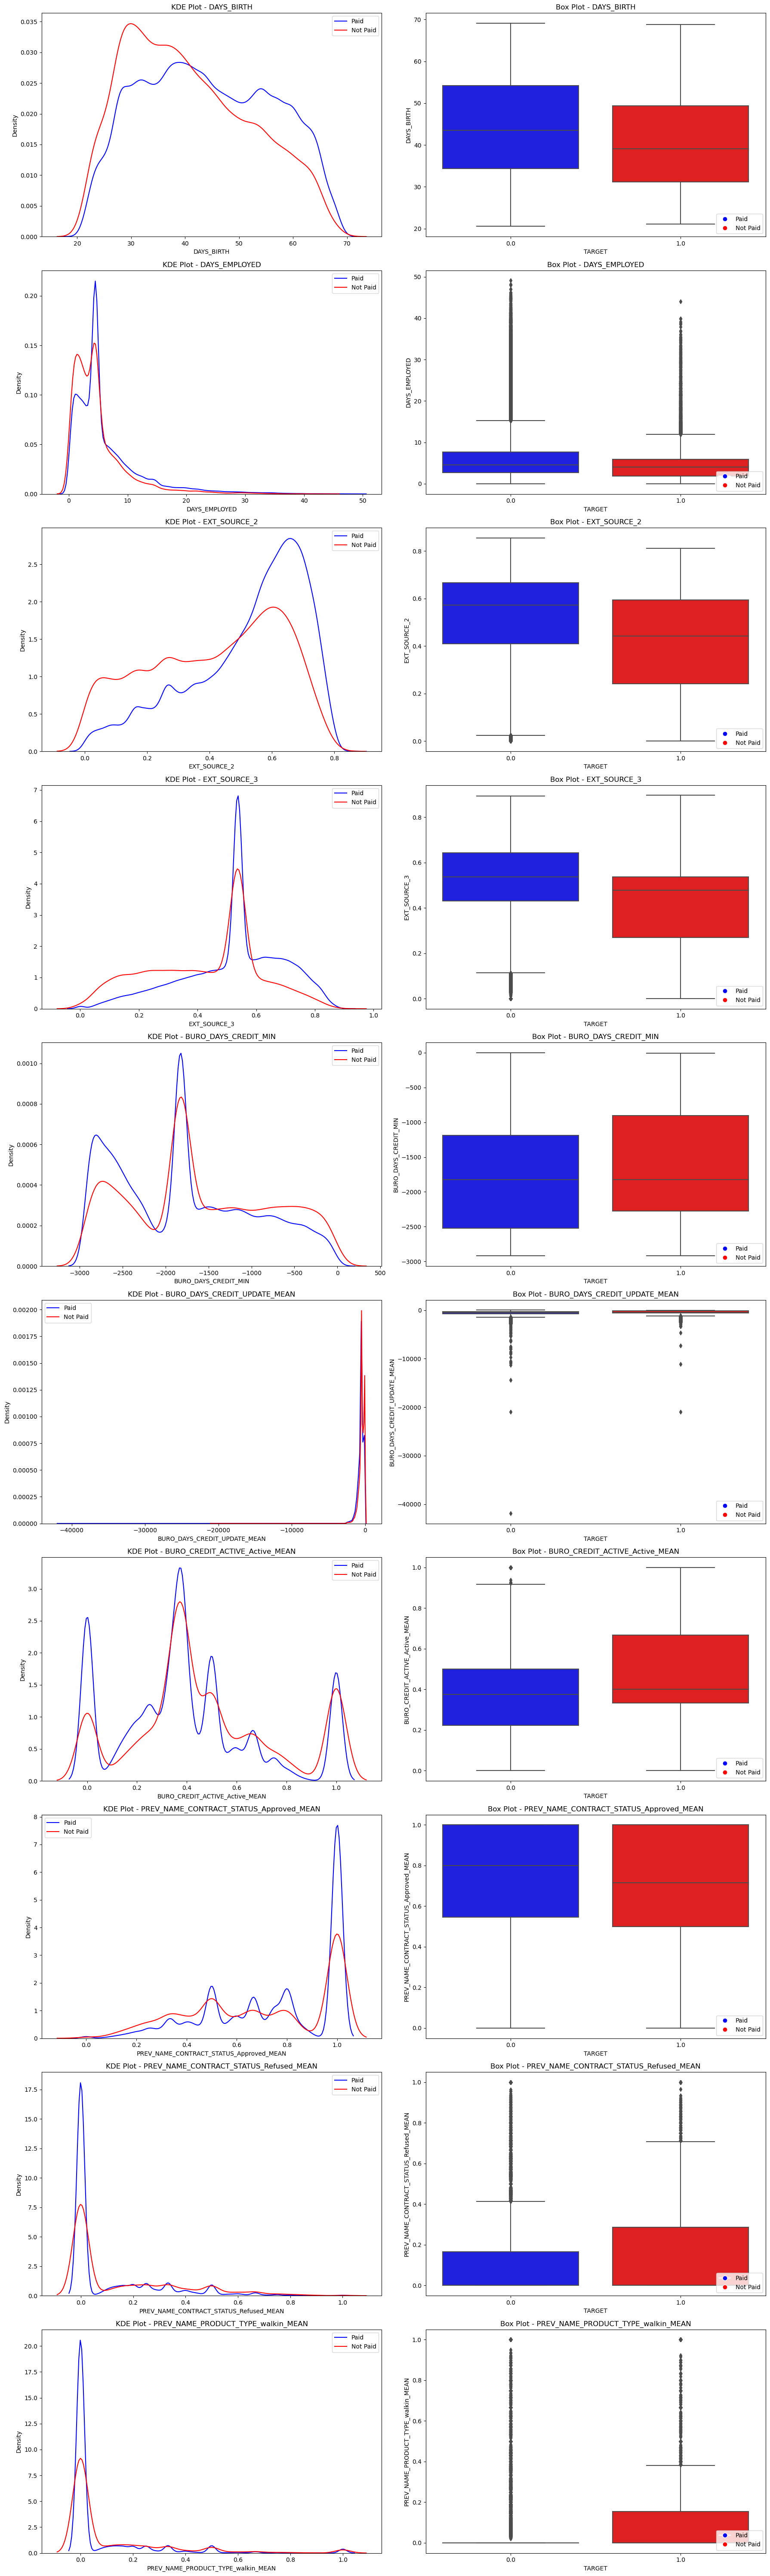

In [40]:
kdeplot_and_boxplot_by_target(df_correlation, "TARGET", most_corr_target, figsize=(18, 6))

### On va mettre à l'échelle(scaler) les colonnes

In [41]:
scaler =  StandardScaler()
#scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_corr)
X_test_scaled = scaler.transform(X_test_corr)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=cols_train, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=cols_test, index=X_test.index)
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(246005, 409)
(61502, 409)


In [42]:
X_test_scaled.head(3)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
343913         0.720924     -0.717489        -0.665211     -0.577535   
281768         0.720924     -0.717489        -0.665211     -0.577535   
215345         0.720924     -0.717489        -0.665211      0.809633   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                              
343913             -0.216620    0.387191     0.644464   
281768             -0.216620    1.199632     0.320462   
215345             -0.130181   -0.747354    -0.496384   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
343913                       -1.026464    0.991715      -0.282717   
281768                       -1.283180   -0.979982      -0.345732   
215345                       -0.084811   -0.959078      -0.802166   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
SK_ID_CURR                                                       
343913               1.068059        -0.543985       -2.135019   
281768               1.253195        -0.081154        0.468380   
215345               1.303170         1.066640        0.468380   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
343913            -0.498768          0.043658   -0.625028   -0.245444   
281768            -0.498768          0.043658    1.599928   -0.245444   
215345             2.004942          0.043658   -0.625028   -0.245444   

            REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                  
343913                 -0.104342                 0.899170   
281768                  1.859443                -0.630415   
215345                 -0.104342                -1.242249   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
343913                       -0.123809                   -0.231497   
281768                       -0.123809                   -0.231497   
215345                       -0.123809                   -0.231497   

            REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
SK_ID_CURR                                                                 
343913                   -0.291159               -0.547714      0.030433   
281768                   -0.291159               -0.547714      0.360033   
215345                   -0.291159                1.825771     -0.158852   

            EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                                     
343913          0.118993                 -0.587593                 -0.319781   
281768          0.883285                 -0.172953                 -0.319781   
215345          0.118993                 -0.587593                 -0.319781   

            DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
343913                    0.372526         -0.00727        -1.563268   
281768                    0.423330         -0.00727         0.639685   
215345                    0.824919         -0.00727         0.639685   

            FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                      
343913            -0.008789         -0.12472         3.208339   
281768            -0.008789         -0.12472        -0.311688   
215345            -0.008789         -0.12472        -0.311688   

            FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  \
SK_ID_CURR                                                      
343913            -0.013375        -0.298182        -0.062885   
2

# Data pour comparaison voisins

In [43]:
cols_prep = ['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CODE_GENDER',
 'PAYMENT_RATE',
 'DAYS_EMPLOYED',
 'INSTAL_DPD_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'NAME_EDUCATION_TYPE_Highereducation',
 'DAYS_BIRTH',
 'AMT_ANNUITY', 'TARGET']

In [44]:
df_X_train_scaled = X_train_scaled.copy()
df_X_train_scaled["TARGET"] = y_train

In [45]:
data_knn = df_X_train_scaled[cols_prep ]
data_knn_sample = data_knn.sample(10000, random_state=42)
#data_knn_sample.to_csv("data_knn_sample.csv")

# Equilibrage

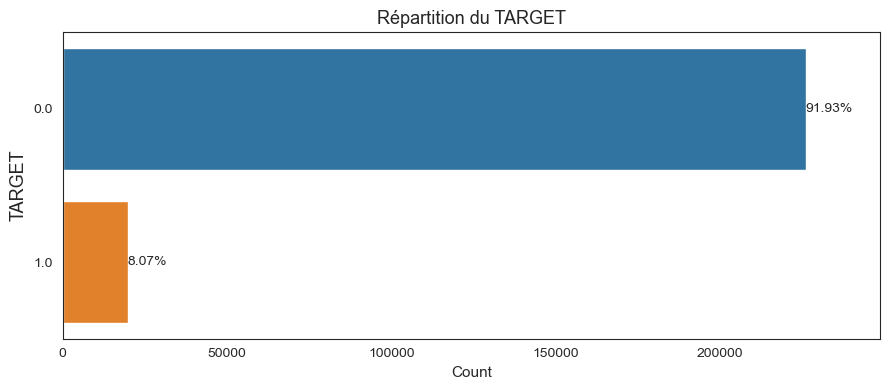

In [46]:
plt.style.use('default')
functions.countplot(df_correlation, "TARGET", figsize=(9, 4))

In [48]:
# Under sampling
undersample = RandomUnderSampler(sampling_strategy="majority", random_state=42)
X_unders, y_unders = undersample.fit_resample(X_train_scaled, y_train)
print("Before using RandomUnderSampler:", Counter(y_train))
print("Under sampled dataset shape", Counter(y_unders))

# Over sampling
oversample = SMOTE(random_state=42)
X_overs, y_overs = oversample.fit_resample(X_train_scaled, y_train)
print("Before using SMOTE:", Counter(y_train))
print("Over sampled dataset shape", Counter(y_overs))

Before using RandomUnderSampler: Counter({0.0: 226145, 1.0: 19860})
Under sampled dataset shape Counter({0.0: 19860, 1.0: 19860})
Before using SMOTE: Counter({0.0: 226145, 1.0: 19860})
Over sampled dataset shape Counter({0.0: 226145, 1.0: 226145})


# Modelisation

In [49]:
def fonction_metier(y_test, y_pred):
   
    
    coeff_tp = 0      # Vrais positifs
    coeff_fp = -1       # Faux positifs 
    coeff_fn = -10     # Faux négatifs 
    coeff_tn = 0       # Vrais négatifs
    
    (tn, fp, fn, tp) = metrics.confusion_matrix(y_test, y_pred).ravel()
    total = (coeff_tn*tn + coeff_fp*fp + coeff_fn*fn + coeff_tp*tp)
    
    #total_neg = tn + fp    # total negatives cases
    #total_pos = tp + fn    # total positives cases
    
    #calcul du gain maximal que peut avoir la banque quand il n'y a pas de perte d'argent.
    #C'est à dire que le modèle ne détecte que TN et les TP.
    max_gain = (tn + fp)*coeff_tn + (tp + fn)*coeff_tp
    #calcul du gain minimal (perte) que peut avoir la banque quand il n'y a pas de gain d'argent.
    #C'est à dire que le modèle ne détecte que FN et les FP.
    min_gain = (tn + fp)*coeff_fp + (tp + fn)*coeff_fn
    #normalisation  : score= (tot-min)/(max-min) 
    gain = (total - min_gain)/(max_gain - min_gain)   
    return gain

In [50]:
def conf_matrix_roc_curve(y_test, y_pred, y_pred_proba, figsize):
    '''Function for plotting Confusion Matrix and ROC Curve.'''
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Confusion Matrix
    ax1 = axes[0]
    ax1.set_title('Confusion Matrix')
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['TN', 'FP', 'FN', 'TP']
    group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax1, annot_kws={"size": 18})
    ax1.set_ylabel('True Label', fontsize=18)  # Increase font size for ylabel
    ax1.set_xlabel('Predicted Label', fontsize=18)  # Increase font size for xlabel
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')

    # ROC Curve
    ax2 = axes[1]
    ax2.set_title('ROC Curve')
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='steelblue', linewidth=5, label=f'AUC = {auc:.2f}', markersize=18)
    ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend()
    ax2.set_xlabel('False Positive Rate', fontsize=18)  # Increase font size for xlabel
    ax2.set_ylabel('True Positive Rate', fontsize=18)  # Increase font size for ylabel
    ax2.legend(fontsize=18)  # Increase font size for legend
    plt.tight_layout()
    plt.show()

    return cf_matrix

In [51]:
from sklearn.metrics import make_scorer

cost_scorer = make_scorer(fonction_metier, greater_is_better=True)

In [52]:
def evaluation_score(model, X_train, y_train, X_test, y_test, model_name, figsize):
    '''
    Calculate, display, and save different metrics.
    
    :param model: The machine learning model to evaluate.
    :param X_train: Training data.
    :param y_train: Target labels for training data.
    :param X_test: Testing data.
    :param y_test: True labels for testing data.
    :param figsize: Tuple specifying the figure size for ROC curve.
    :param model_name: Name of the model (for result DataFrame).
    :return: A DataFrame with metrics.
    '''
    start_time = time.time()
    model.fit(X_train, y_train)
    execution_time = time.time() - start_time
    execution_time = round(execution_time,3)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metier = fonction_metier(y_test, y_pred).round(2)
    accuracy = metrics.accuracy_score(y_test, y_pred).round(2)
    precision = metrics.precision_score(y_test, y_pred).round(2)
    recall = metrics.recall_score(y_test, y_pred).round(2)
    f1_score = metrics.f1_score(y_test, y_pred).round(2)
    auc_score = metrics.roc_auc_score(y_test, y_pred_proba).round(2)
    
    # Display classification report
    print(classification_report(y_test, y_pred))
    
    # Display confusion matrix and ROC curve
    conf_matrix_roc_curve(y_test, y_pred, y_pred_proba, figsize)
    
    # Create a DataFrame with rounded metrics
    results = pd.DataFrame({'model': [model_name],
                            'accuracy': [accuracy],
                            'precision': [precision],
                            'recall': [recall],
                            'f1_score': [f1_score],
                            'roc_auc_score': [auc_score],
                            'custom_score': [metier],
                            'execution_time': [execution_time]})
    display(results)
    
    return results, precision, recall, f1_score, auc_score, metier

In [54]:
mlflow.set_tracking_uri("/Users/zeyneperdem/Desktop/ds_prep/p7/mlruns")

In [55]:
tracking_uri = mlflow.get_tracking_uri()

In [56]:
tracking_uri

'/Users/zeyneperdem/Desktop/ds_prep/p7/mlruns'

In [53]:
from mlflow.models.signature import infer_signature

In [54]:
def mlfow_track(exp_name, model, X_train, y_train, X_test, y_test, model_name, figsize):
    model = model
    signature = infer_signature(X_train, y_train)
    plt.style.use('fivethirtyeight')
    mlflow.set_experiment(exp_name)
    mlflow.sklearn.autolog()
    mlflow.lightgbm.autolog()
    with mlflow.start_run(run_name=exp_name):
        model.fit(X_train, y_train)
        results, precision, recall, f1_score, auc_score,\
        metier = evaluation_score(model, X_train, y_train, X_test, y_test, model_name, figsize) 
        #mlflow.log_param("class_weight", class_weight)
        #mlflow.log_param("max_iter", max_iter)
        mlflow.log_metric("custom_score", metier)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1_score)
        mlflow.log_metric("rocauc", auc_score)
        #mlflow.sklearn.log_model(model, "model", registered_model_name=model_name, signature=signature)
        #mlflow.lightgbm.log_model(model, "model", registered_model_name=model_name, signature=signature)
    return model, results

# Logistic Regression

## Avec data origine

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.50      0.02      0.04      4965

    accuracy                           0.92     61502
   macro avg       0.71      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502



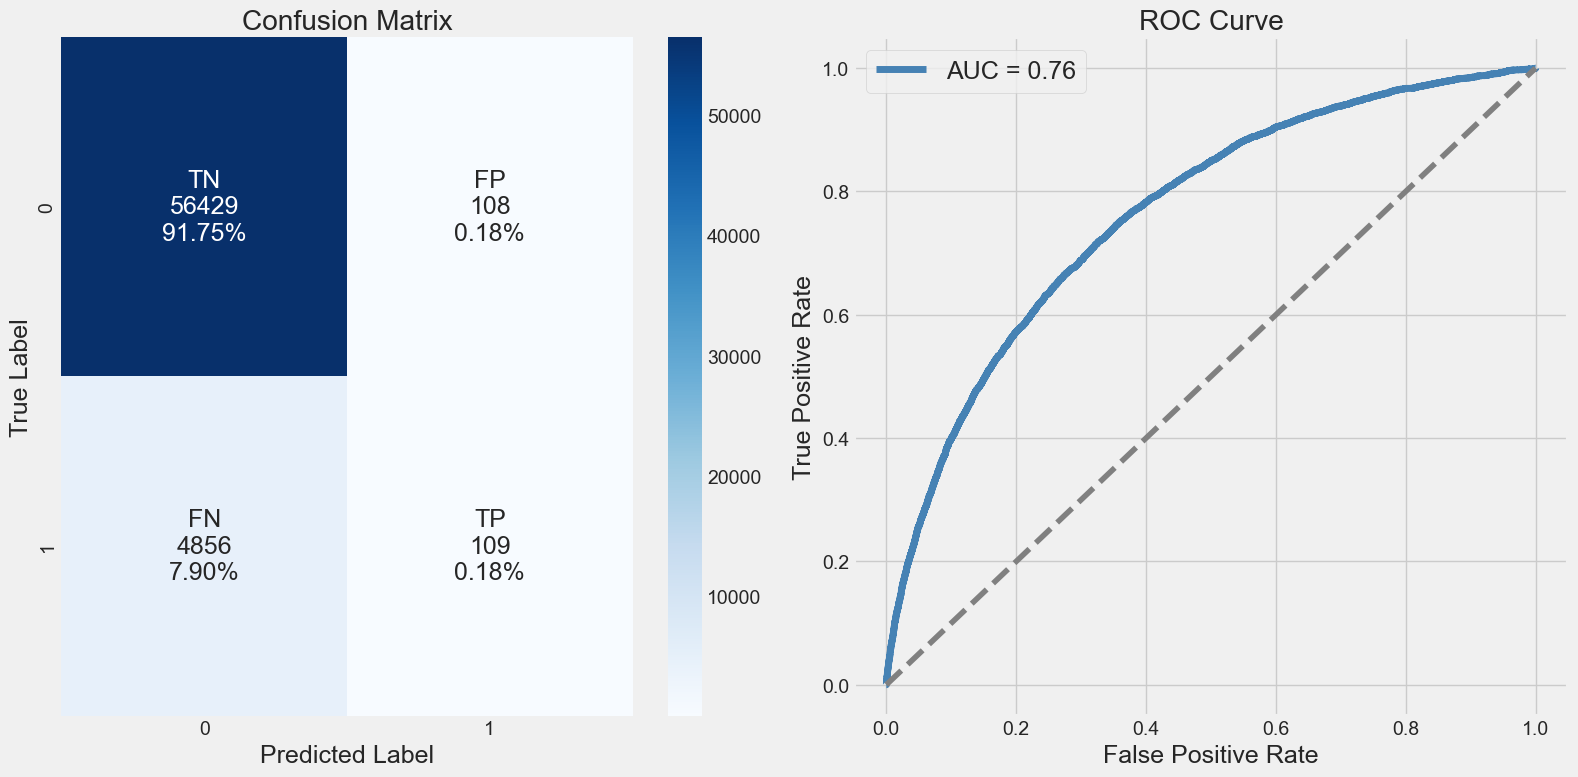

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_origine      0.92        0.5    0.02      0.04           0.76   

   custom_score  execution_time  
0          0.54          17.098

In [59]:
model = LogisticRegression()
lr_origine, results_lr_origine = mlfow_track("lr_origine", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "lr_origine", (16,8))

# Undersampled

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.69      0.27      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.69      0.54     61502
weighted avg       0.90      0.69      0.76     61502



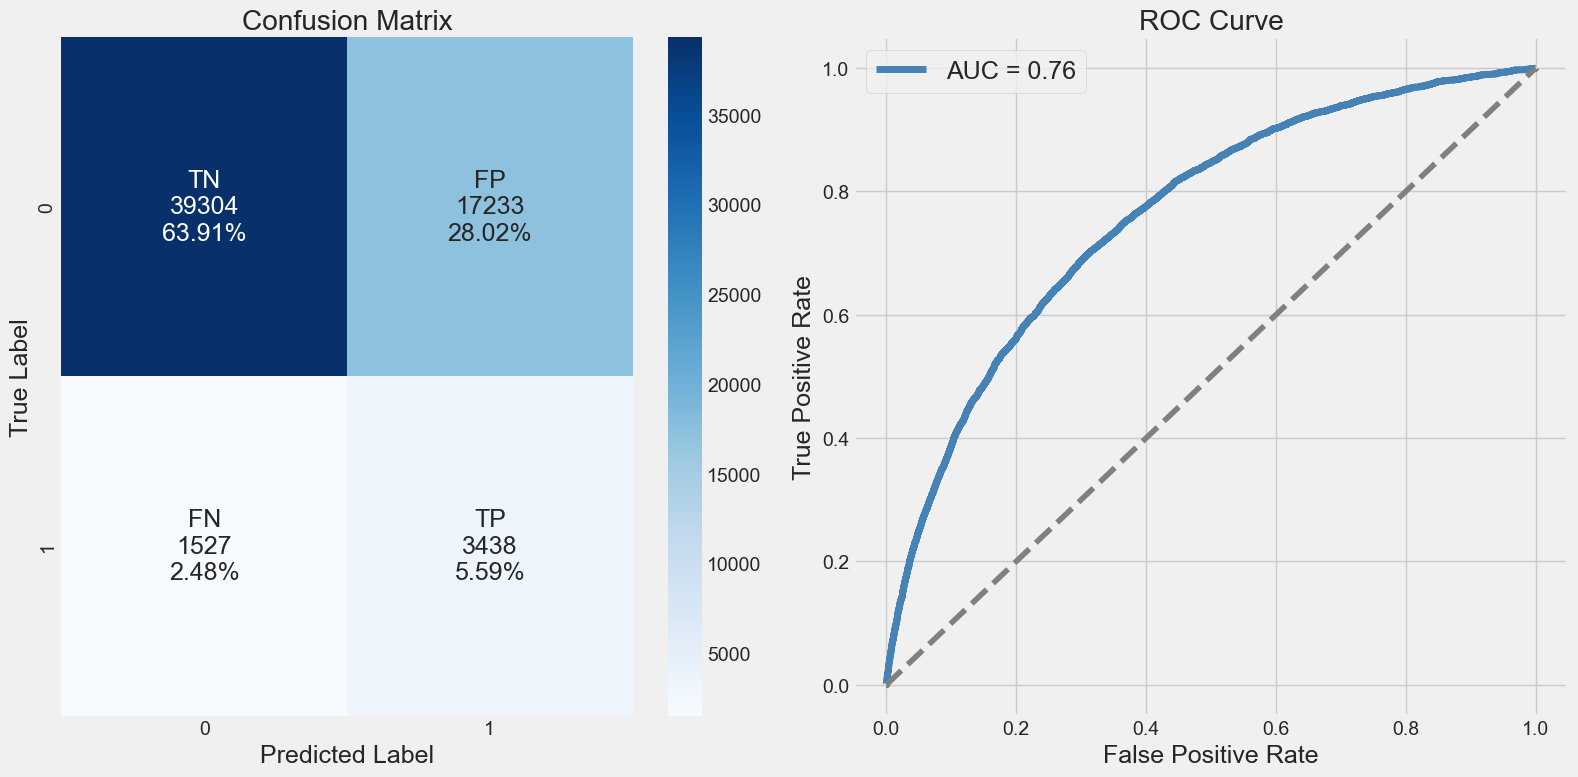

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_unders      0.69       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0          0.69           4.029

In [60]:
model = LogisticRegression()
lr_unders, results_lr_unders = mlfow_track("lr_unders", model,
                             X_unders, y_unders, X_test_scaled, y_test, "lr_unders", (16,8))

In [61]:
lr_unders

LogisticRegression()

In [62]:
results_lr_unders

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_unders      0.69       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0          0.69           4.029

# Oversampled

              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     56537
         1.0       0.17      0.65      0.26      4965

    accuracy                           0.71     61502
   macro avg       0.56      0.68      0.54     61502
weighted avg       0.89      0.71      0.77     61502



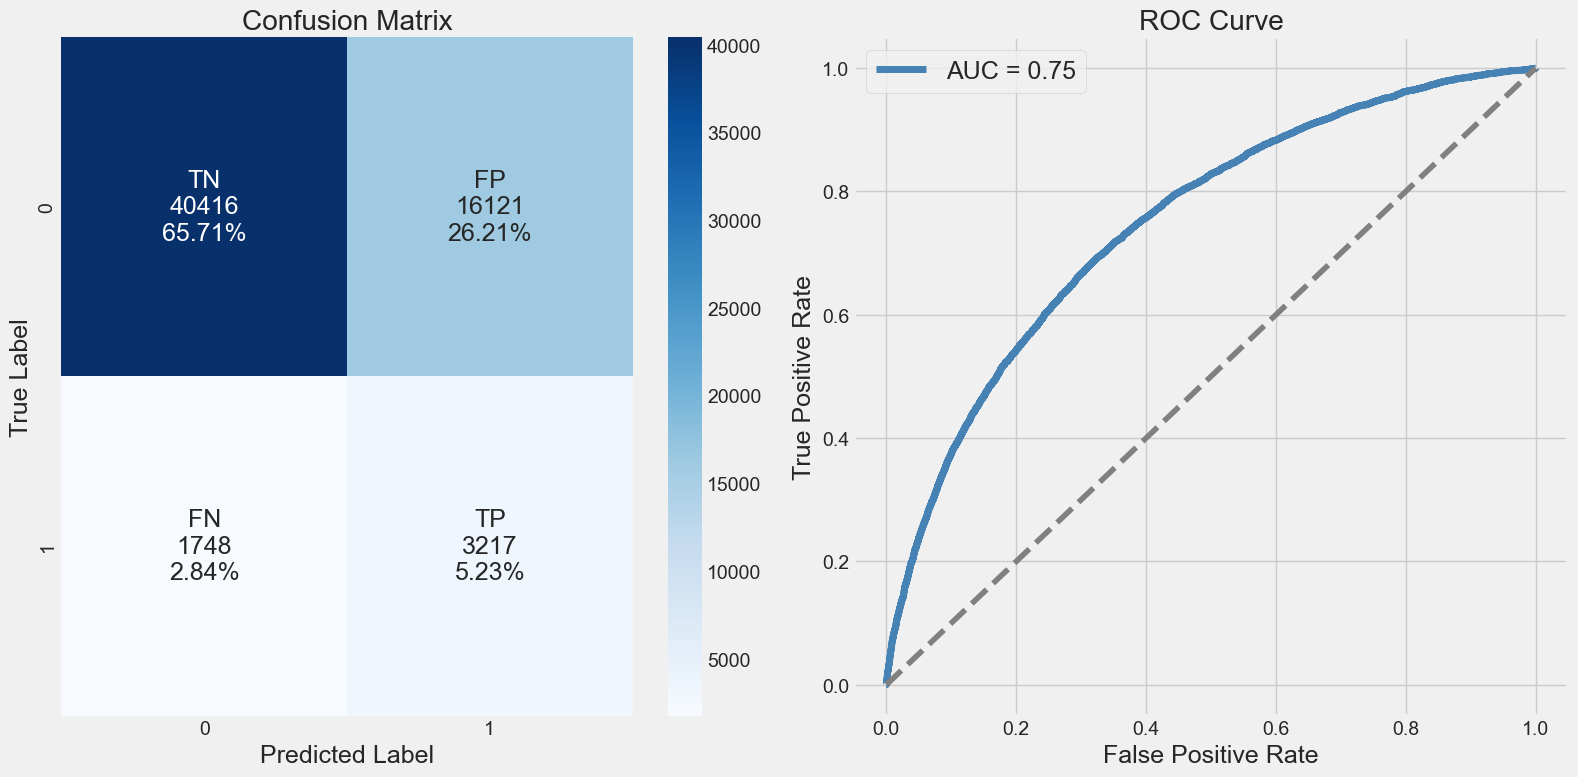

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_overs      0.71       0.17    0.65      0.26           0.75   

   custom_score  execution_time  
0          0.68          31.023

In [63]:
model = LogisticRegression()
lr_overs, results_lr_overs = mlfow_track("lr_overs", model,
                             X_overs, y_overs, X_test_scaled, y_test, "lr_overs", (16,8))

# Class weigth balanced

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.69      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.70      0.54     61502
weighted avg       0.90      0.70      0.77     61502



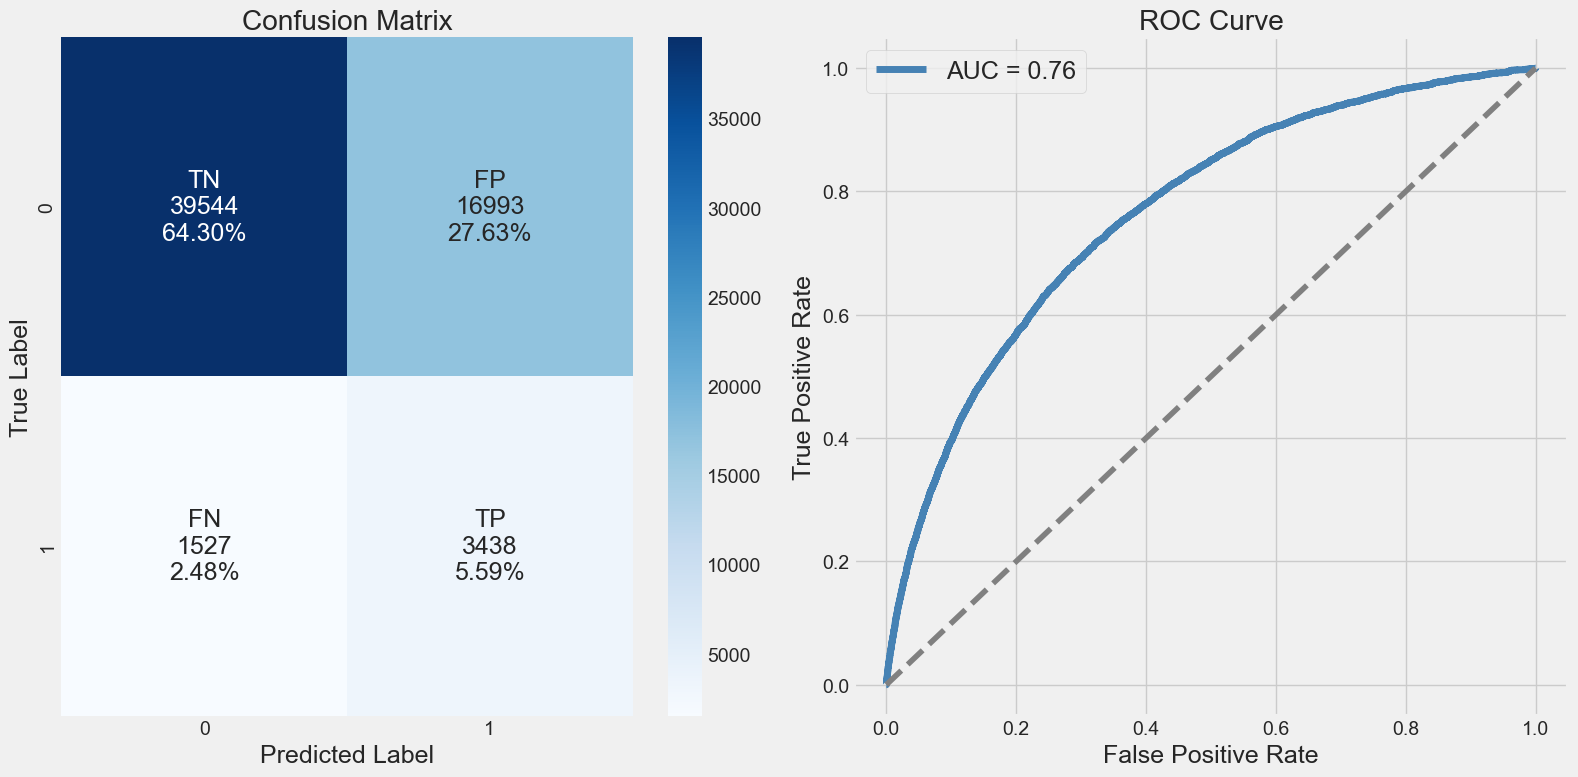

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_balanced       0.7       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0           0.7          15.732

In [64]:
model = LogisticRegression(class_weight="balanced")
lr_balanced, results_lr_balanced = mlfow_track("lr_balanced", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "lr_balanced", (16,8))

## Comparaison des résultas Logistic Regression

In [65]:
comp_lr = pd.concat([results_lr_origine, results_lr_unders, results_lr_overs, results_lr_balanced], axis=0)
comp_lr

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0   lr_origine      0.92       0.50    0.02      0.04           0.76   
0    lr_unders      0.69       0.17    0.69      0.27           0.76   
0     lr_overs      0.71       0.17    0.65      0.26           0.75   
0  lr_balanced      0.70       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0          0.54          17.098  
0          0.69           4.029  
0          0.68          31.023  
0          0.70          15.732

# Random Forest

# Data origine

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.78      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.85      0.50      0.48     61502
weighted avg       0.91      0.92      0.88     61502



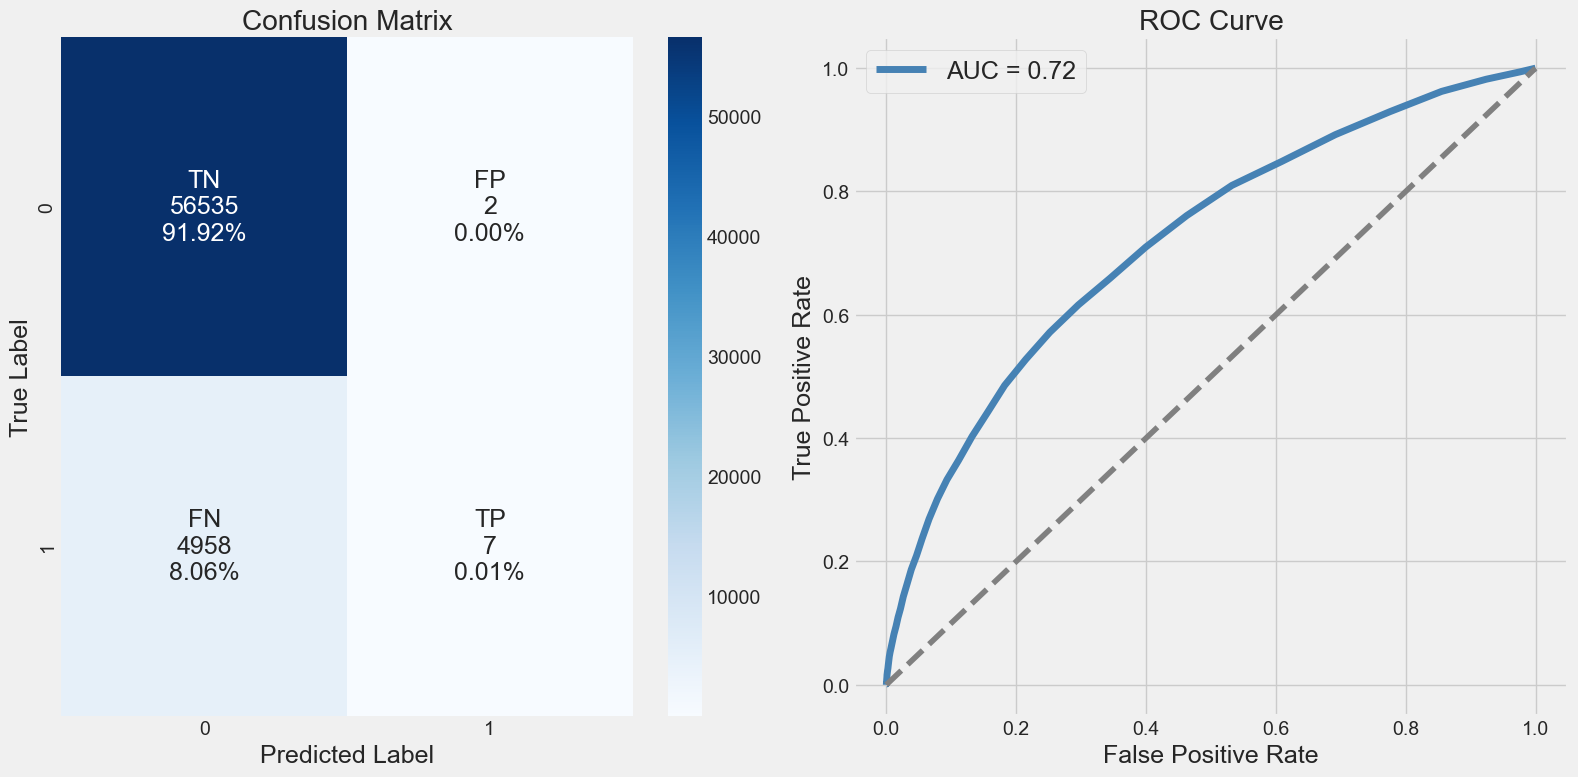

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  rf_origine      0.92       0.78     0.0       0.0           0.72   

   custom_score  execution_time  
0          0.53         166.569

In [66]:
model = RandomForestClassifier(random_state=42)
rf_origine, results_rf_origine = mlfow_track("rf_origine", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "rf_origine", (16,8))

# Undersampled

              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     56537
         1.0       0.16      0.68      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.68      0.53     61502
weighted avg       0.90      0.69      0.76     61502



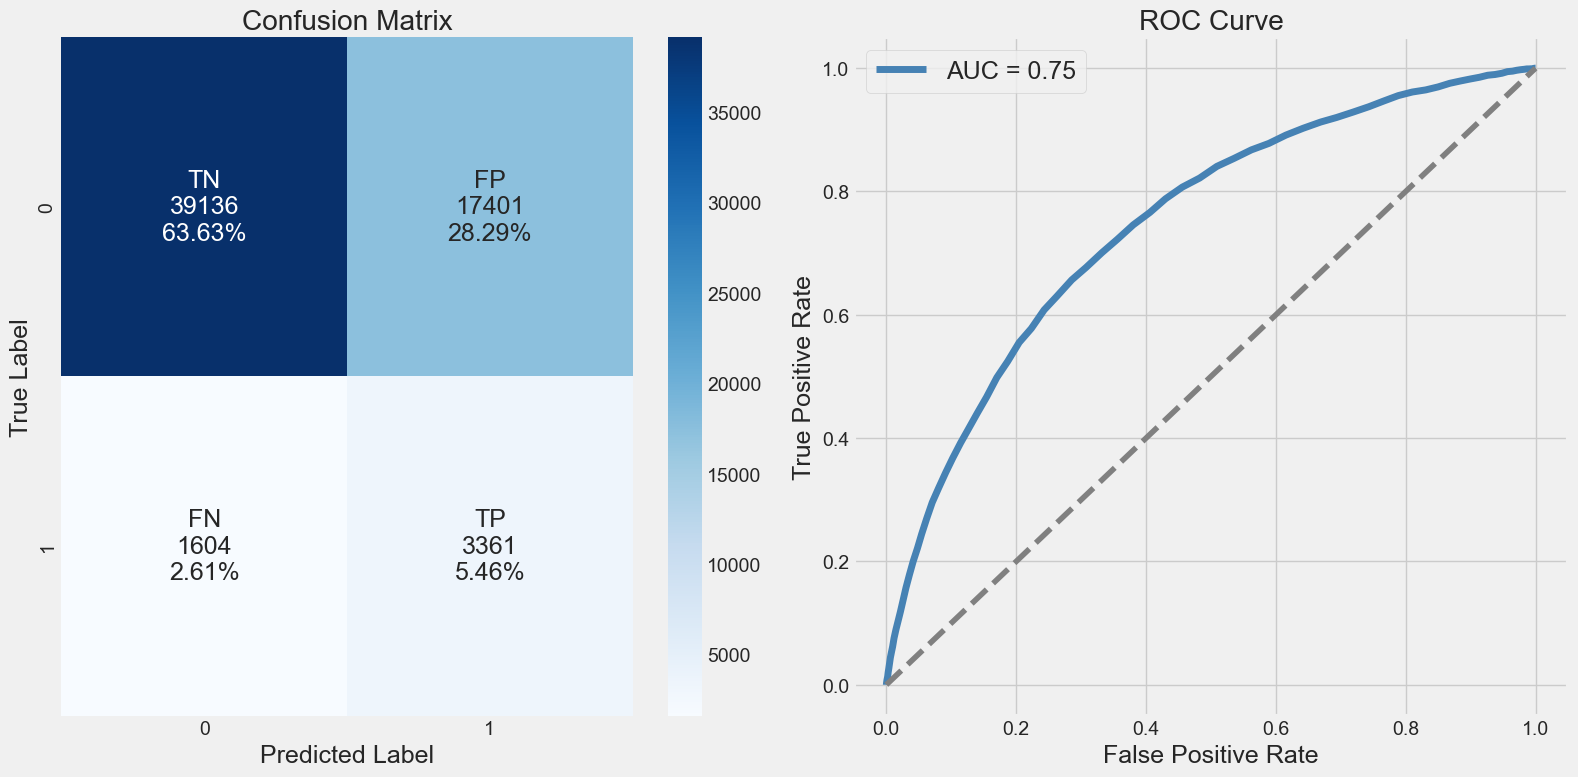

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  rf_unders      0.69       0.16    0.68      0.26           0.75   

   custom_score  execution_time  
0          0.69           19.92

In [67]:
model = RandomForestClassifier(random_state=42)
rf_unders, results_rf_unders = mlfow_track("rf_unders", model,
                             X_unders, y_unders, X_test_scaled, y_test, "rf_unders", (16,8))

## Oversampled

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.35      0.03      0.05      4965

    accuracy                           0.92     61502
   macro avg       0.63      0.51      0.50     61502
weighted avg       0.87      0.92      0.88     61502



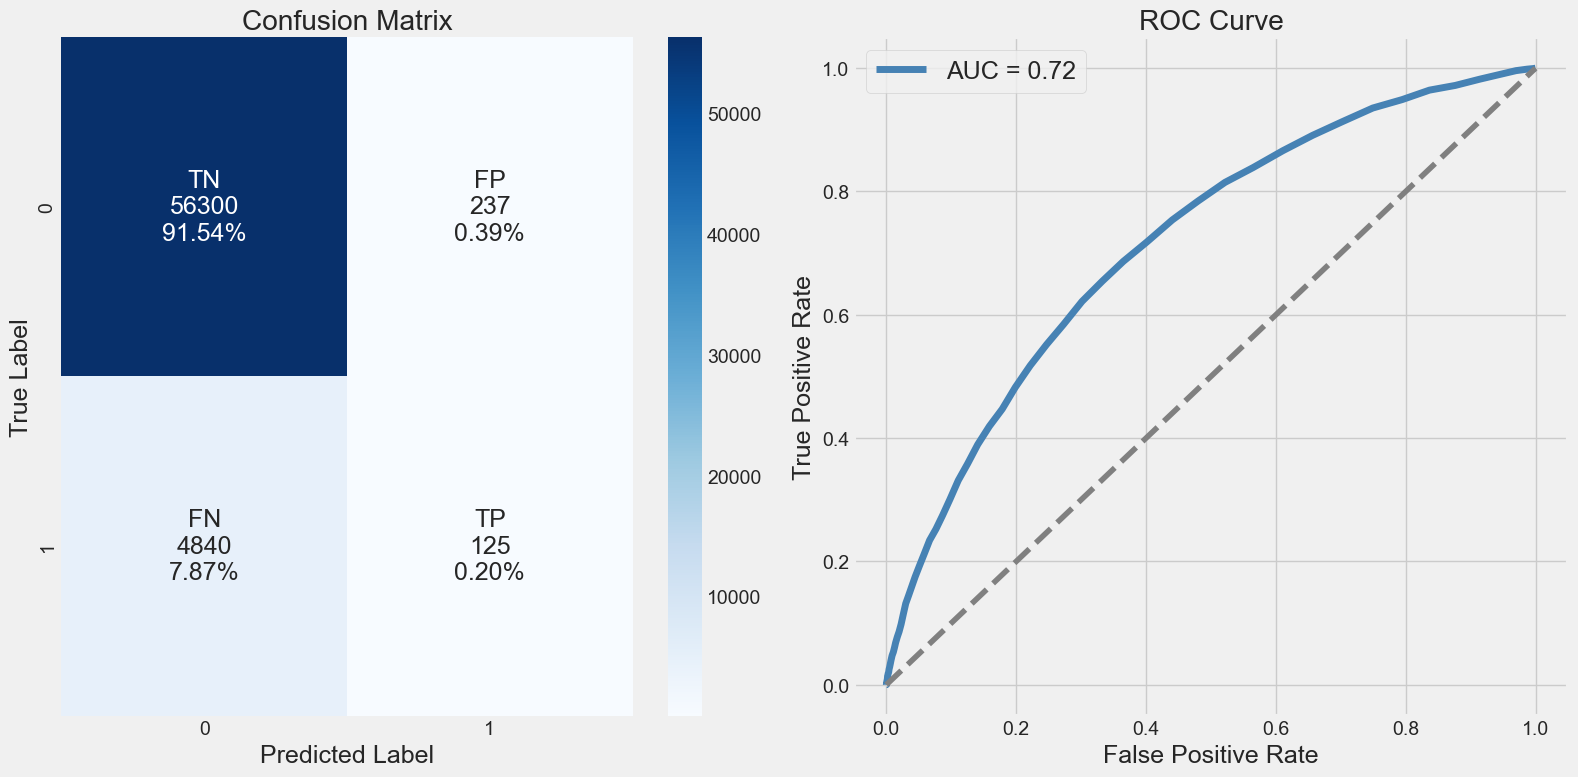

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  rf_overs      0.92       0.35    0.03      0.05           0.72   

   custom_score  execution_time  
0          0.54          311.69

In [69]:
model = RandomForestClassifier(random_state=42)
rf_overs, results_rf_overs = mlfow_track("rf_overs", model,
                             X_overs, y_overs, X_test_scaled, y_test, "rf_overs", (16,8))

# Class weigth balanced

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.59      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.75      0.50      0.48     61502
weighted avg       0.89      0.92      0.88     61502



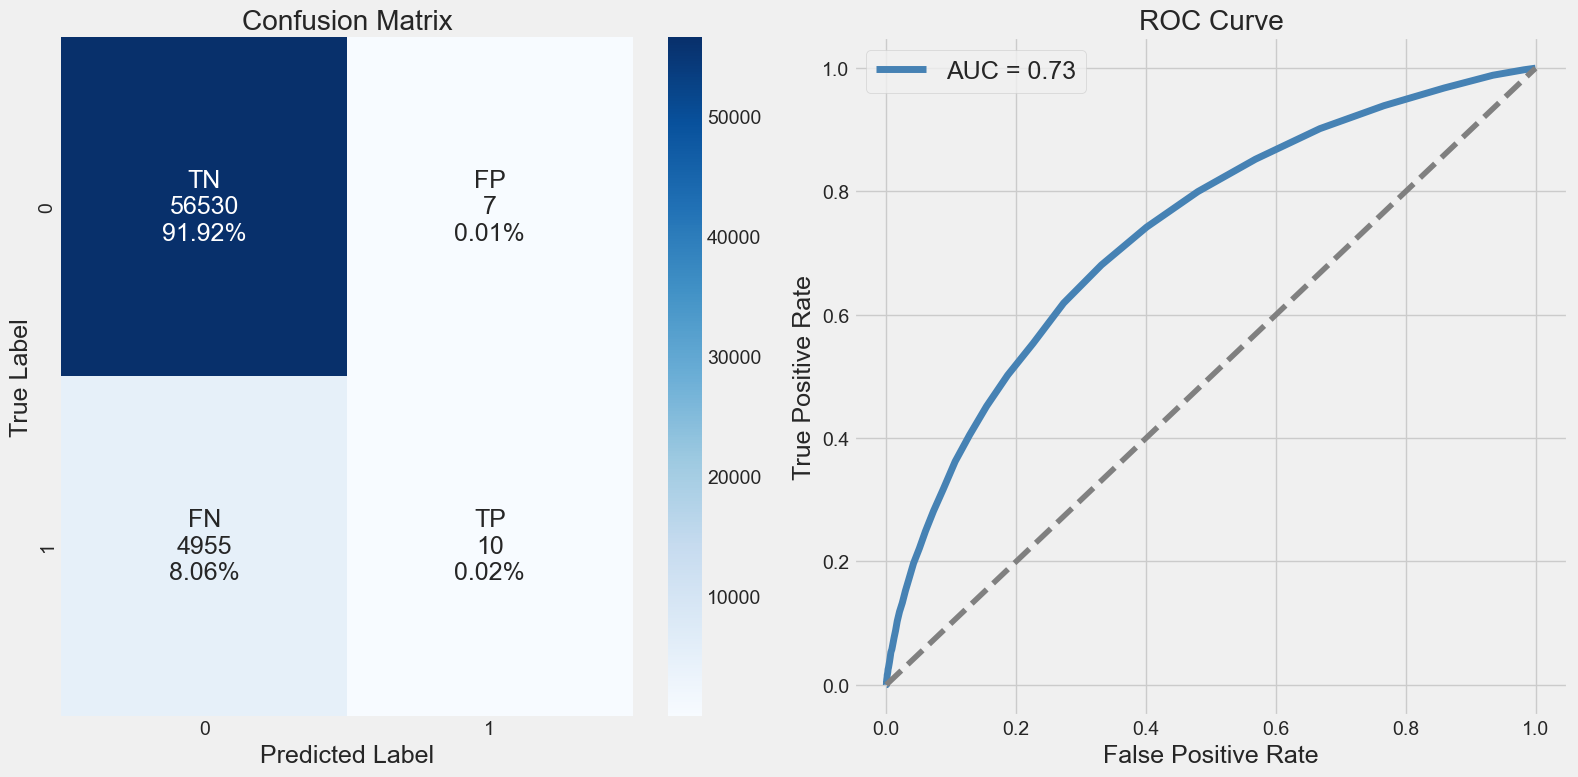

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  rf_balanced      0.92       0.59     0.0       0.0           0.73   

   custom_score  execution_time  
0          0.53         127.001

In [68]:
model = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_balanced, results_rf_balanced = mlfow_track("rf_balanced", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "rf_balanced", (16,8))

## Comparaison des résultas Random Forest

In [70]:
comp_rf = pd.concat([results_rf_origine, results_rf_unders, results_rf_overs, results_rf_balanced], axis=0)
comp_rf

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0   rf_origine      0.92       0.78    0.00      0.00           0.72   
0    rf_unders      0.69       0.16    0.68      0.26           0.75   
0     rf_overs      0.92       0.35    0.03      0.05           0.72   
0  rf_balanced      0.92       0.59    0.00      0.00           0.73   

   custom_score  execution_time  
0          0.53         166.569  
0          0.69          19.920  
0          0.54         311.690  
0          0.53         127.001

# Lightgbm

# Data origine

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.55      0.03      0.06      4965

    accuracy                           0.92     61502
   macro avg       0.74      0.52      0.51     61502
weighted avg       0.89      0.92      0.89     61502



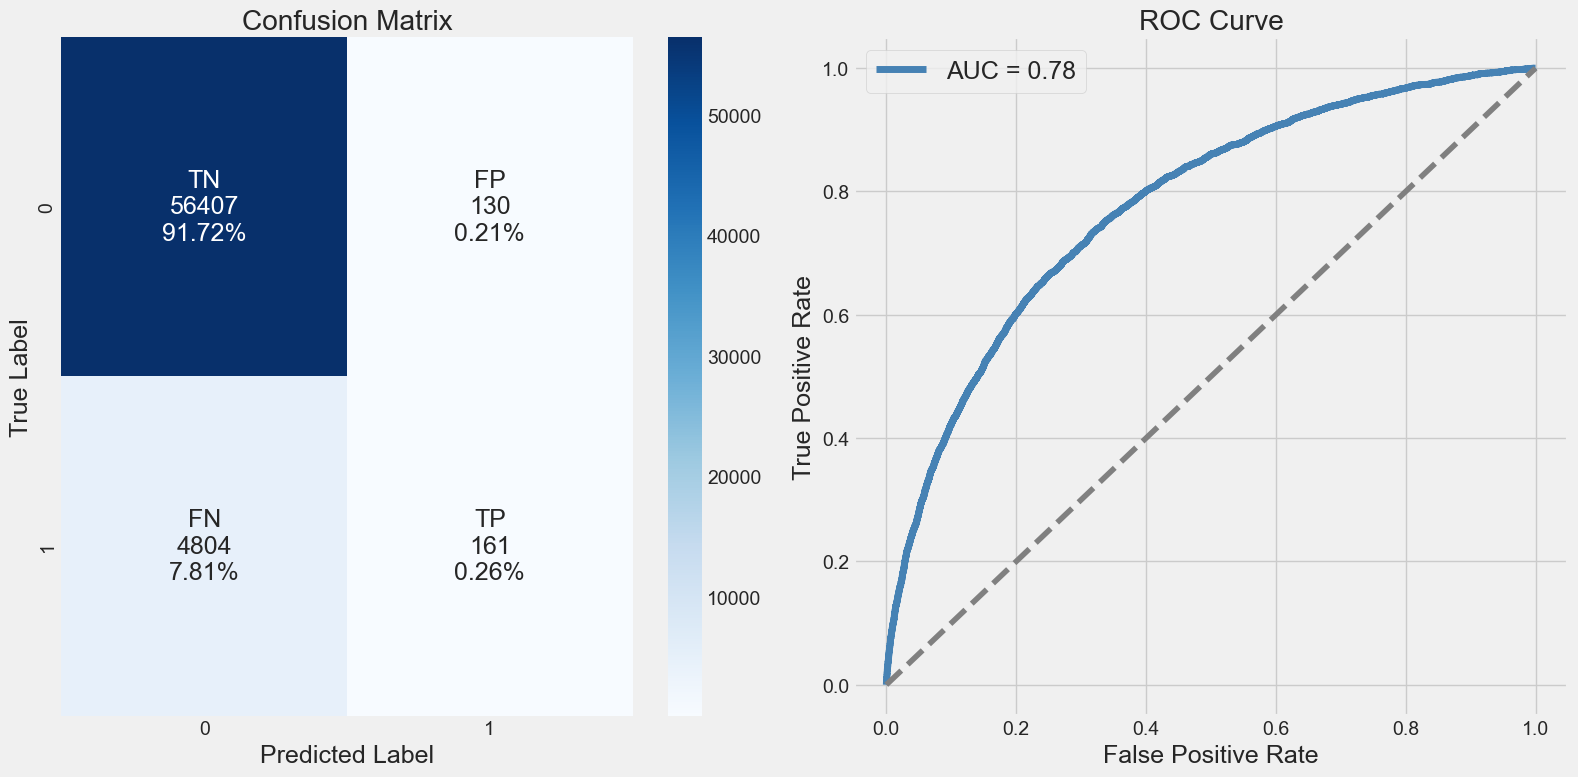

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_origine      0.92       0.55    0.03      0.06           0.78   

   custom_score  execution_time  
0          0.55          14.535

In [71]:
model = LGBMClassifier(random_state=42)
lgbm_origine, results_lgbm_origine = mlfow_track("lgbm_origine", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "lgbm_origine", (16,8))

# Undersampled

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.70      0.28      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.70      0.54     61502
weighted avg       0.90      0.70      0.77     61502



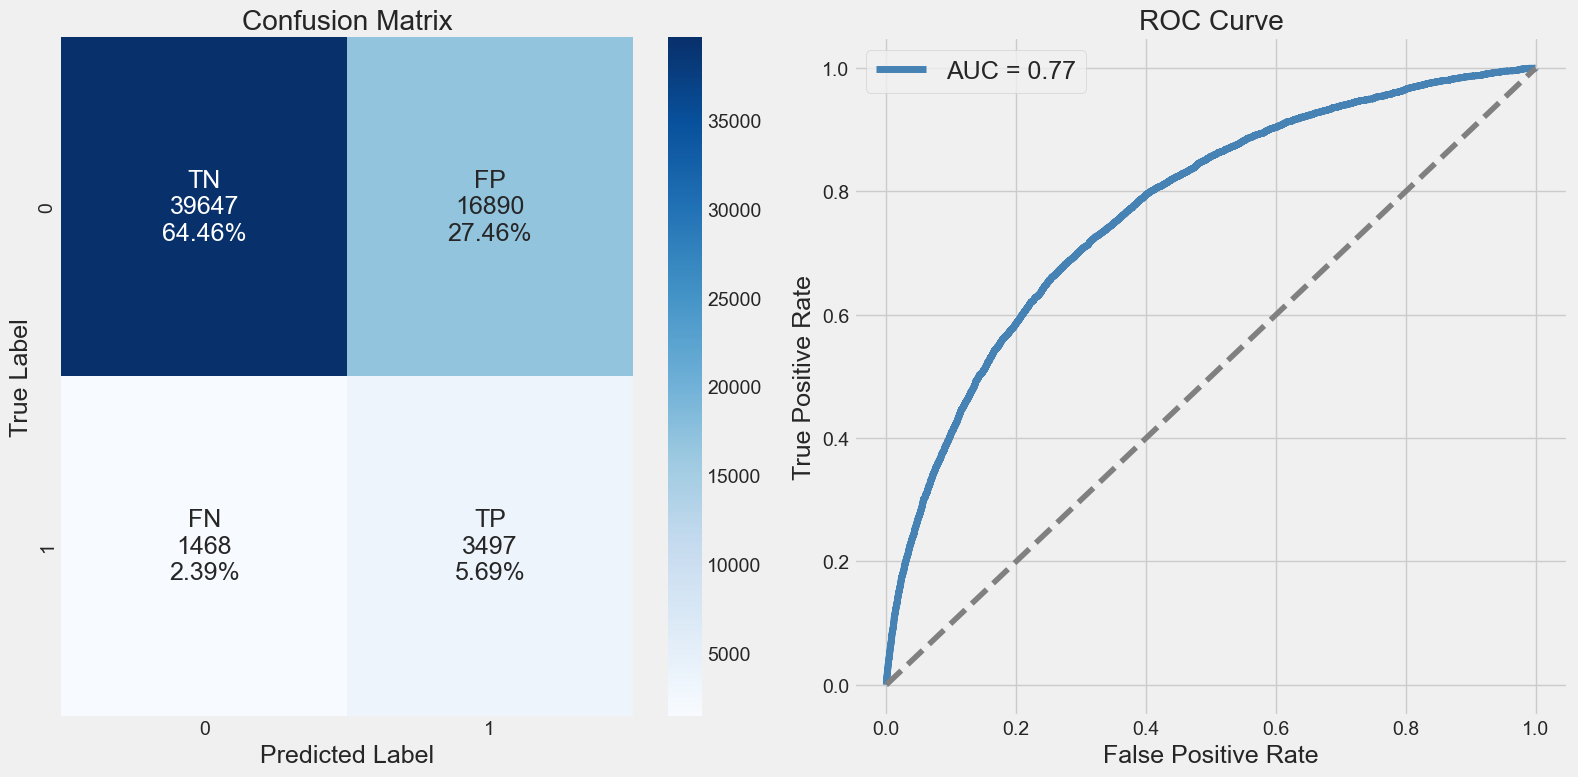

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_unders       0.7       0.17     0.7      0.28           0.77   

   custom_score  execution_time  
0           0.7           5.846

In [72]:
model = LGBMClassifier(random_state=42)
lgbm_unders, results_lgbm_unders = mlfow_track("lgbm_unders", model,
                             X_unders, y_unders, X_test_scaled, y_test, "lgbm_unders", (16,8))

## Oversampled

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.52      0.03      0.05      4965

    accuracy                           0.92     61502
   macro avg       0.72      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502



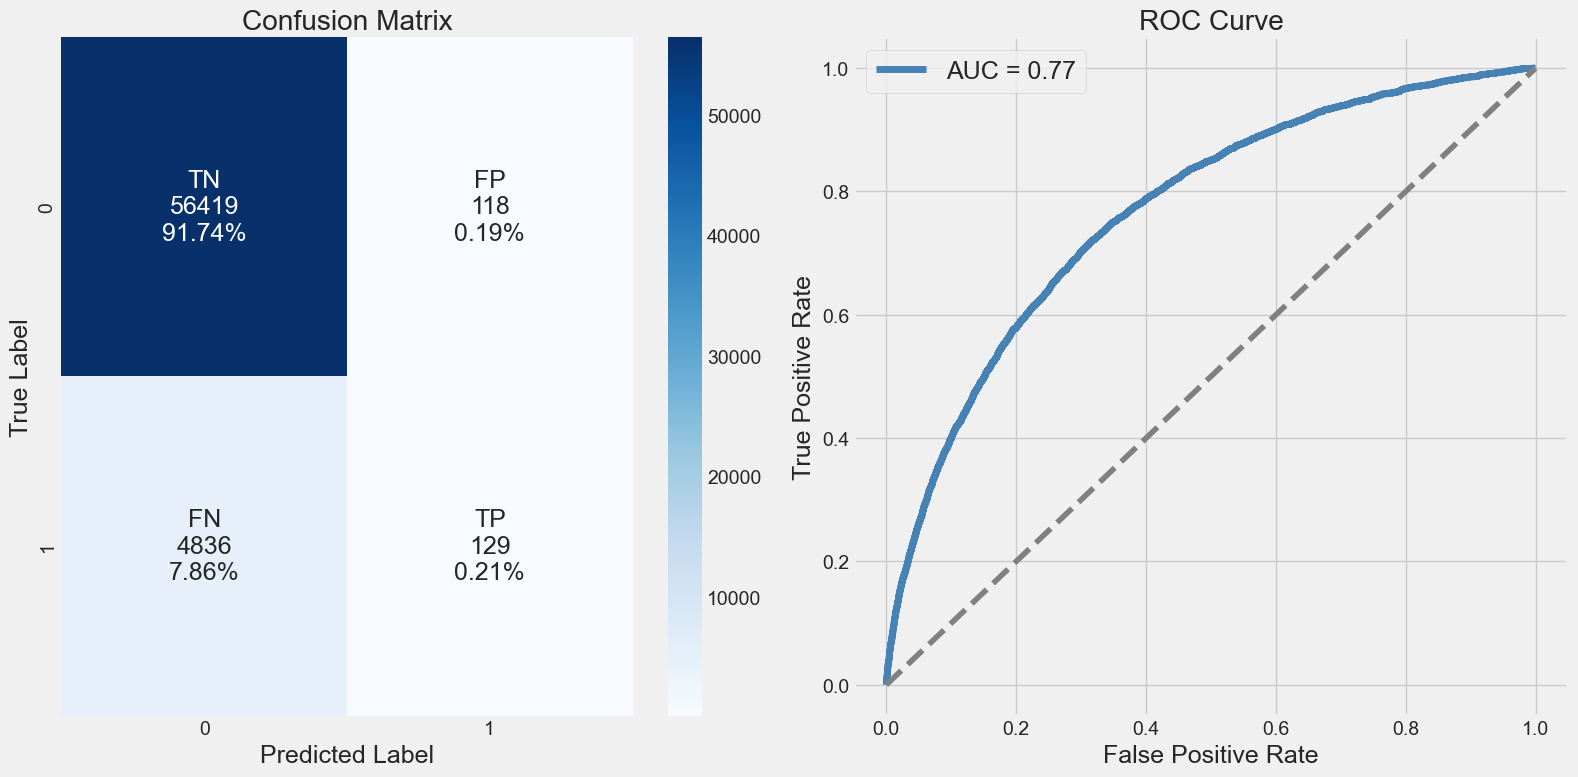

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_overs      0.92       0.52    0.03      0.05           0.77   

   custom_score  execution_time  
0          0.54          28.776

In [73]:
model = LGBMClassifier(random_state=42)
lgbm_overs, results_lgbm_overs = mlfow_track("lgbm_overs", model,
                             X_overs, y_overs, X_test_scaled, y_test, "lgbm_overs", (16,8))

# Class weigth balanced

              precision    recall  f1-score   support

         0.0       0.96      0.72      0.83     56537
         1.0       0.18      0.69      0.29      4965

    accuracy                           0.72     61502
   macro avg       0.57      0.71      0.56     61502
weighted avg       0.90      0.72      0.78     61502



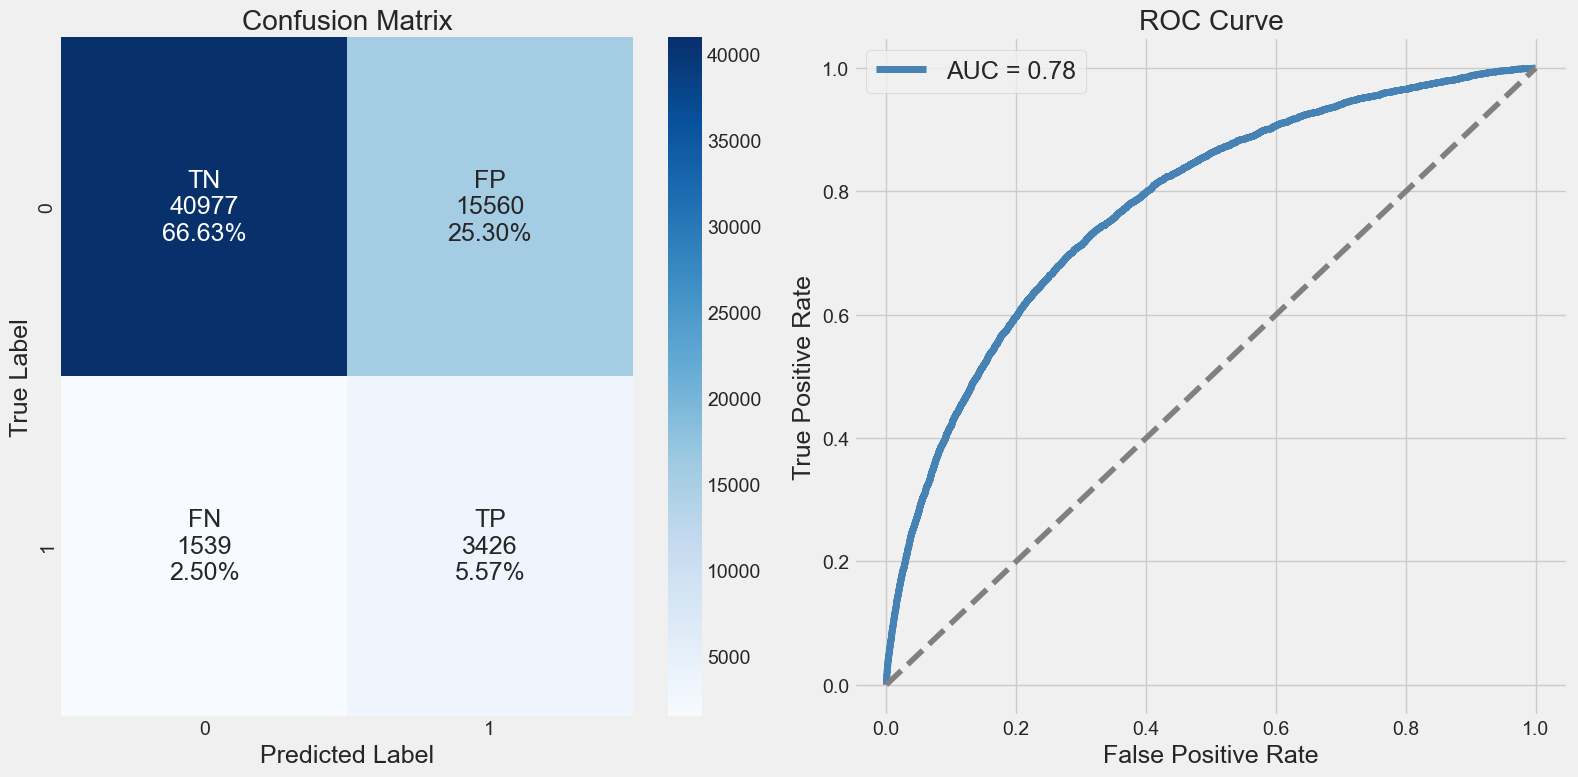

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_balanced      0.72       0.18    0.69      0.29           0.78   

   custom_score  execution_time  
0          0.71          15.773

In [59]:
model = LGBMClassifier(class_weight="balanced", random_state=42)
lgbm_balanced, results_lgbm_balanced = mlfow_track("lgbm_balanced", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "lgbm_balanced", (16,8))

In [60]:
lgbm_balanced

LGBMClassifier(class_weight='balanced', random_state=42)

## Comparaison des résultas LGBM

In [76]:
comp_lgbm = pd.concat([results_lgbm_origine, results_lgbm_unders, results_lgbm_overs, results_lgbm_balanced], axis=0)
comp_lgbm

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0   lgbm_origine      0.92       0.55    0.03      0.06           0.78   
0    lgbm_unders      0.70       0.17    0.70      0.28           0.77   
0     lgbm_overs      0.92       0.52    0.03      0.05           0.77   
0  lgbm_balanced      0.72       0.18    0.69      0.29           0.78   

   custom_score  execution_time  
0          0.55          14.535  
0          0.70           5.846  
0          0.54          28.776  
0          0.71          14.838

# Comparaison Total

In [77]:
comp_total = pd.concat([comp_lr, comp_rf, comp_lgbm], axis=0)
comp_total.sort_values("roc_auc_score", ascending=False)

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0   lgbm_origine      0.92       0.55    0.03      0.06           0.78   
0  lgbm_balanced      0.72       0.18    0.69      0.29           0.78   
0    lgbm_unders      0.70       0.17    0.70      0.28           0.77   
0     lgbm_overs      0.92       0.52    0.03      0.05           0.77   
0     lr_origine      0.92       0.50    0.02      0.04           0.76   
0      lr_unders      0.69       0.17    0.69      0.27           0.76   
0    lr_balanced      0.70       0.17    0.69      0.27           0.76   
0       lr_overs      0.71       0.17    0.65      0.26           0.75   
0      rf_unders      0.69       0.16    0.68      0.26           0.75   
0    rf_balanced      0.92       0.59    0.00      0.00           0.73   
0     rf_origine      0.92       0.78    0.00      0.00           0.72   
0       rf_overs      0.92       0.35    0.03      0.05           0.72   

   custom_score  execution_time  
0          0.55          14.535  
0          0.71          14.838  
0          0.70           5.846  
0          0.54          28.776  
0          0.54          17.098  
0          0.69           4.029  
0          0.70          15.732  
0          0.68          31.023  
0          0.69          19.920  
0          0.53         127.001  
0          0.53         166.569  
0          0.54         311.690

# Explainability

In [55]:
import shap
shap.initjs()

In [61]:
X_test_scaled.shape

(61502, 409)

# Feature Importance pour lgbm balanced

In [62]:
# Affichage des features importance
def show_feature_importance(model,  data, name):
    
    feat_imp = model.feature_importances_
    df_feat_imp = pd.DataFrame(feat_imp, columns = ["Feature Importance"])
    df_feat_imp["Feature Name"] = data.columns
    df_feat_imp = df_feat_imp.sort_values(by="Feature Importance", ascending=False)
    display(df_feat_imp.head(10))   
    # Affichage Features importance
    plt.barh(df_feat_imp.head(10)["Feature Name"], df_feat_imp.head(10)["Feature Importance"])
    plt.xlabel("Feature Importance")
    plt.title(f"Feature importance pour le modele {name} ")
    plt.show()
    return None

Feature Importance             Feature Name
183                 186             PAYMENT_RATE
23                  125             EXT_SOURCE_2
24                  108             EXT_SOURCE_3
8                    91               DAYS_BIRTH
257                  78    PREV_CNT_PAYMENT_MEAN
9                    62            DAYS_EMPLOYED
6                    56              AMT_ANNUITY
393                  52          INSTAL_DPD_MEAN
11                   52          DAYS_ID_PUBLISH
380                  51  POS_MONTHS_BALANCE_SIZE

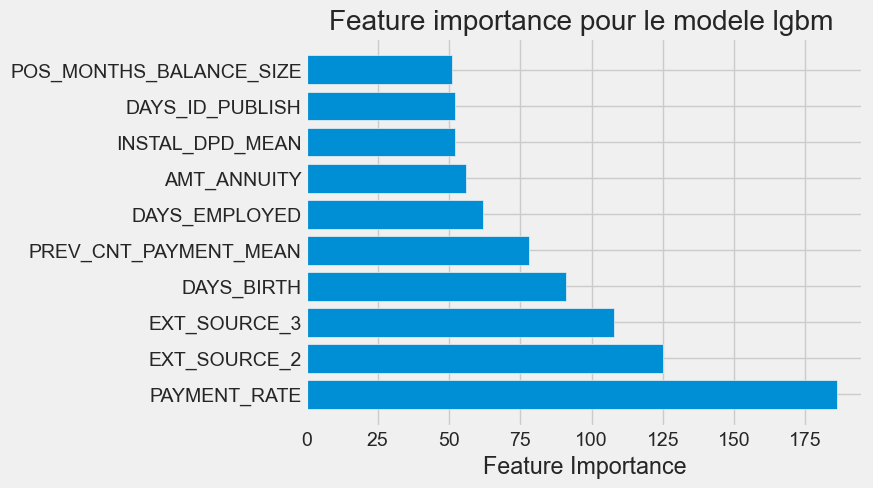

In [63]:
model = lgbm_balanced
show_feature_importance(model,  X_test_scaled, "lgbm")

# Summary Plot

Below we have generated a summary plot with plot type as bar based on shape values generated from test data using the explainer. The bar chart shows the average impact of each feature on the final prediction. This also highlights feature importance based on shap values.
The summary plot can handle multi-class shap values. Below we have generated a summary plot of test data and it defaults to a bar chart for multi-class problems. We can see how much each attribute contributes on average for each class type.

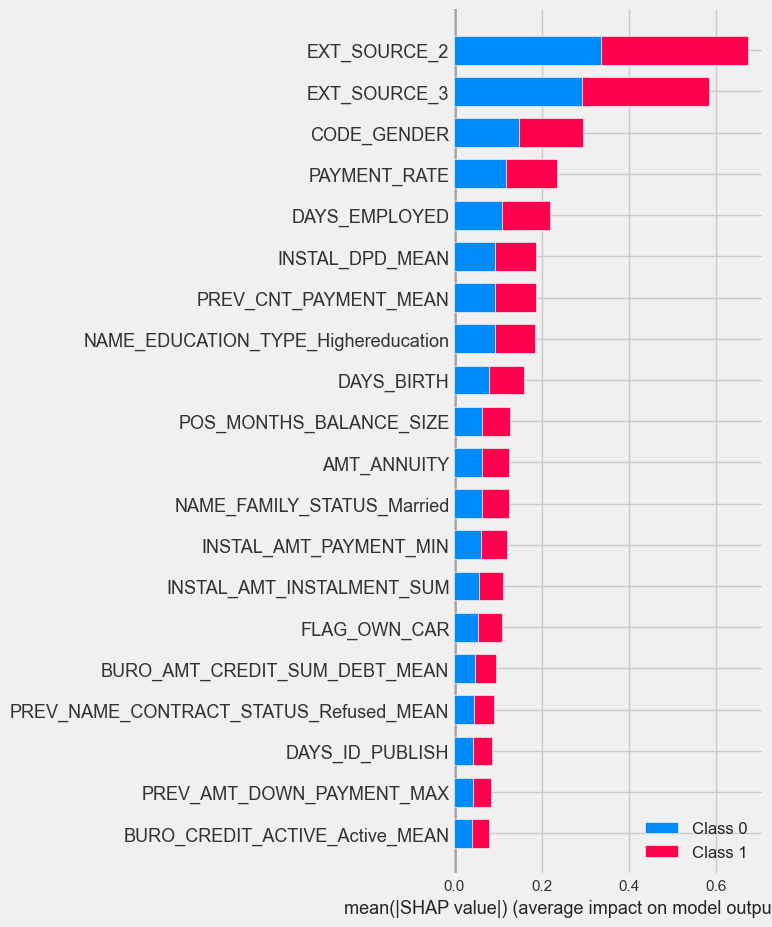

In [64]:
# Explain model predictions using shap library:
model = lgbm_balanced
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)
# Plot summary_plot
shap.summary_plot(shap_values, X_test_scaled)

In [65]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_test_scaled.columns, sum(vals))),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(11)

col_name  feature_importance_vals
23                          EXT_SOURCE_2             20646.564231
24                          EXT_SOURCE_3             17903.116258
0                            CODE_GENDER              9082.964732
183                         PAYMENT_RATE              7212.477684
9                          DAYS_EMPLOYED              6703.165211
393                      INSTAL_DPD_MEAN              5767.690414
257                PREV_CNT_PAYMENT_MEAN              5735.043725
70   NAME_EDUCATION_TYPE_Highereducation              5672.766191
8                             DAYS_BIRTH              4877.065797
380              POS_MONTHS_BALANCE_SIZE              3940.345371
6                            AMT_ANNUITY              3860.142740

In [66]:
cols_importance = feature_importance.head(11).col_name
cols_importance.tolist()

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CODE_GENDER',
 'PAYMENT_RATE',
 'DAYS_EMPLOYED',
 'INSTAL_DPD_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'NAME_EDUCATION_TYPE_Highereducation',
 'DAYS_BIRTH',
 'POS_MONTHS_BALANCE_SIZE',
 'AMT_ANNUITY']

In [67]:
cols_importance = ['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CODE_GENDER',
 'PAYMENT_RATE',
 'DAYS_EMPLOYED',
 'INSTAL_DPD_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'NAME_EDUCATION_TYPE_Highereducation',
 'DAYS_BIRTH',
 'AMT_ANNUITY']

In [68]:
X_test_scaled.head(3)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
343913         0.720924     -0.717489        -0.665211     -0.577535   
281768         0.720924     -0.717489        -0.665211     -0.577535   
215345         0.720924     -0.717489        -0.665211      0.809633   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                              
343913             -0.216620    0.387191     0.644464   
281768             -0.216620    1.199632     0.320462   
215345             -0.130181   -0.747354    -0.496384   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
343913                       -1.026464    0.991715      -0.282717   
281768                       -1.283180   -0.979982      -0.345732   
215345                       -0.084811   -0.959078      -0.802166   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
SK_ID_CURR                                                       
343913               1.068059        -0.543985       -2.135019   
281768               1.253195        -0.081154        0.468380   
215345               1.303170         1.066640        0.468380   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
343913            -0.498768          0.043658   -0.625028   -0.245444   
281768            -0.498768          0.043658    1.599928   -0.245444   
215345             2.004942          0.043658   -0.625028   -0.245444   

            REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                  
343913                 -0.104342                 0.899170   
281768                  1.859443                -0.630415   
215345                 -0.104342                -1.242249   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
343913                       -0.123809                   -0.231497   
281768                       -0.123809                   -0.231497   
215345                       -0.123809                   -0.231497   

            REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
SK_ID_CURR                                                                 
343913                   -0.291159               -0.547714      0.030433   
281768                   -0.291159               -0.547714      0.360033   
215345                   -0.291159                1.825771     -0.158852   

            EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                                     
343913          0.118993                 -0.587593                 -0.319781   
281768          0.883285                 -0.172953                 -0.319781   
215345          0.118993                 -0.587593                 -0.319781   

            DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
343913                    0.372526         -0.00727        -1.563268   
281768                    0.423330         -0.00727         0.639685   
215345                    0.824919         -0.00727         0.639685   

            FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                      
343913            -0.008789         -0.12472         3.208339   
281768            -0.008789         -0.12472        -0.311688   
215345            -0.008789         -0.12472        -0.311688   

            FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  \
SK_ID_CURR                                                      
343913            -0.013375        -0.298182        -0.062885   
2

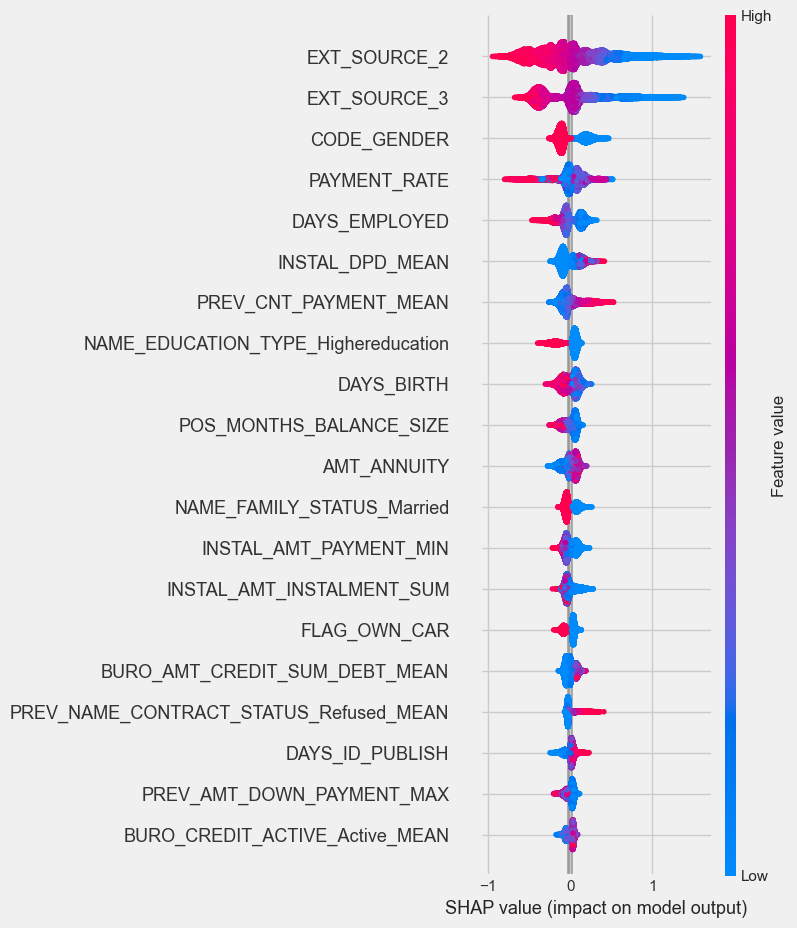

In [69]:
shap.summary_plot(shap_values[1], X_test_scaled, feature_names=X_test_scaled.columns)

100%|===================| 61250/61502 [03:08<00:00]        

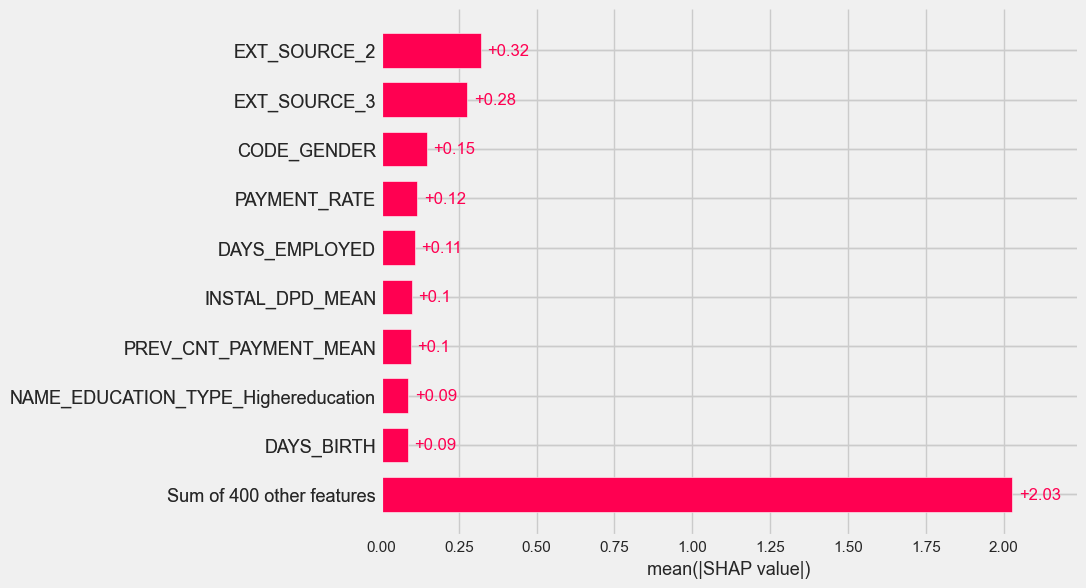

In [101]:
explainer = shap.Explainer(model, X_test_scaled)
shap_values = explainer(X_test_scaled, check_additivity=False)
shap.plots.bar(shap_values)

### Shap pour X_test_sample

In [70]:
X_test_scaled.head(1)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
343913         0.720924     -0.717489        -0.665211     -0.577535   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                              
343913              -0.21662    0.387191     0.644464   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
343913                       -1.026464    0.991715      -0.282717   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
SK_ID_CURR                                                       
343913               1.068059        -0.543985       -2.135019   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
343913            -0.498768          0.043658   -0.625028   -0.245444   

            REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                  
343913                 -0.104342                  0.89917   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
343913                       -0.123809                   -0.231497   

            REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
SK_ID_CURR                                                                 
343913                   -0.291159               -0.547714      0.030433   

            EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                                     
343913          0.118993                 -0.587593                 -0.319781   

            DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
343913                    0.372526         -0.00727        -1.563268   

            FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                      
343913            -0.008789         -0.12472         3.208339   

            FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  \
SK_ID_CURR                                                      
343913            -0.013375        -0.298182        -0.062885   

            FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  FLAG_DOCUMENT_12  \
SK_ID_CURR                                                         
343913             -0.004032          -0.06246         -0.002851   

            FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  \
SK_ID_CURR                                                         
343913              -0.05916         -0.055077         -0.034826   

            FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  \
SK_ID_CURR                                                         
343913             -0.100069         -0.016628         -0.090398   

            FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
SK_ID_CURR                                                         
343913             -0.024865         -0.023082         -0.018036   

            AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                          
343913                       -0.070594                  -0.057613   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
SK_ID_CURR                                                          
343913                       -0.155982                  -0.270371   

            AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  \
SK_ID_CURR                                                          
343913                      -0.294445                   -0.440703   

            NAME_CONTRACT_TYPE_Cashloans  NAME_TYPE_SUITE_Children  \
SK_ID_CU

In [71]:
X_test_sample = X_test_scaled.head(1)
X_test_sample.shape

(1, 409)

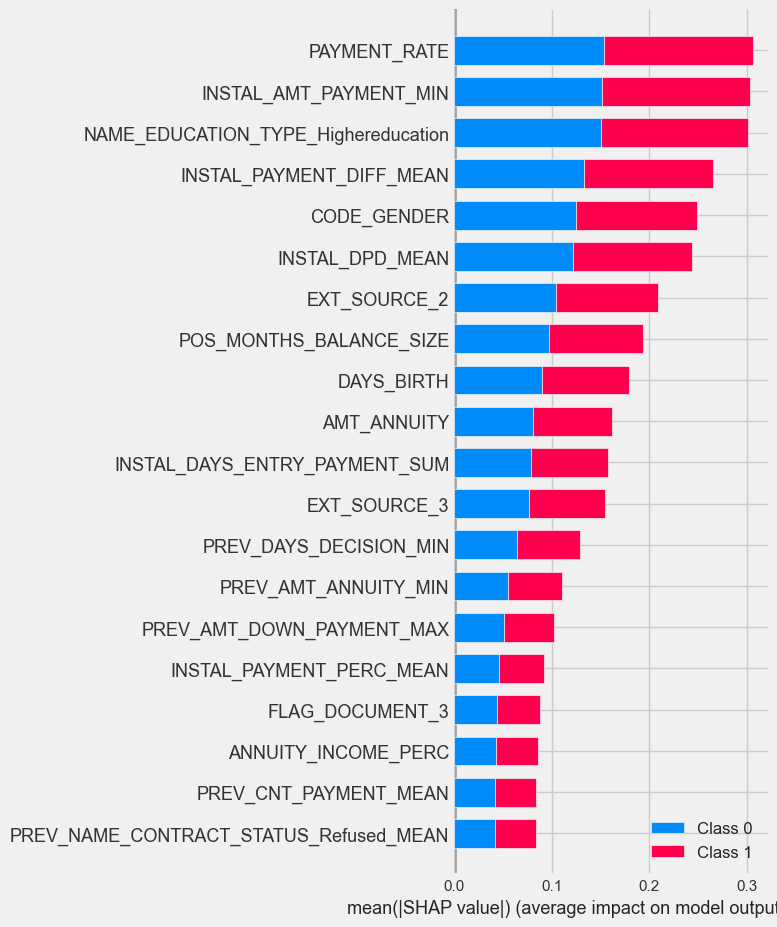

In [72]:
# Explain model predictions using shap library:
model = lgbm_balanced
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample)
# Plot summary_plot
shap.summary_plot(shap_values, X_test_sample)

In [73]:
#shap.summary_plot(shap_values, X_test_sample, feature_names=X_test_sample.columns)

In [74]:
model = lgbm_balanced
#X_test_sample = X_test_scaled.sample(10, random_state=42)
subsampled_test_data =X_test_sample

# explain first sample from test data
start_time = time.time()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(subsampled_test_data)
elapsed_time = time.time() - start_time

print("Tree Explainer SHAP run time", round(elapsed_time,3) , " seconds. ", "lgbm_balanced")
print("SHAP expected value", explainer.expected_value)
print("Model prediction for subsampled_test_data", model.predict_proba(subsampled_test_data))
shap.initjs()
pred_ind = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][0], subsampled_test_data.iloc[0], 
                feature_names=X_train_scaled.columns)

Tree Explainer SHAP run time 0.069  seconds.  lgbm_balanced
SHAP expected value [0.5364358464213156, -0.5364358464213156]
Model prediction for subsampled_test_data [[0.43436395 0.56563605]]


# Model2

In [75]:
cols_importance 

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CODE_GENDER',
 'PAYMENT_RATE',
 'DAYS_EMPLOYED',
 'INSTAL_DPD_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'NAME_EDUCATION_TYPE_Highereducation',
 'DAYS_BIRTH',
 'AMT_ANNUITY']

In [76]:
X_train_imp = X_train_scaled[cols_importance]
X_test_imp = X_test_scaled[cols_importance]
X_test_imp.shape

(61502, 10)

# LGBM Class weigth balanced avec X_train_scaled

              precision    recall  f1-score   support

         0.0       0.96      0.72      0.83     56537
         1.0       0.18      0.69      0.29      4965

    accuracy                           0.72     61502
   macro avg       0.57      0.71      0.56     61502
weighted avg       0.90      0.72      0.78     61502



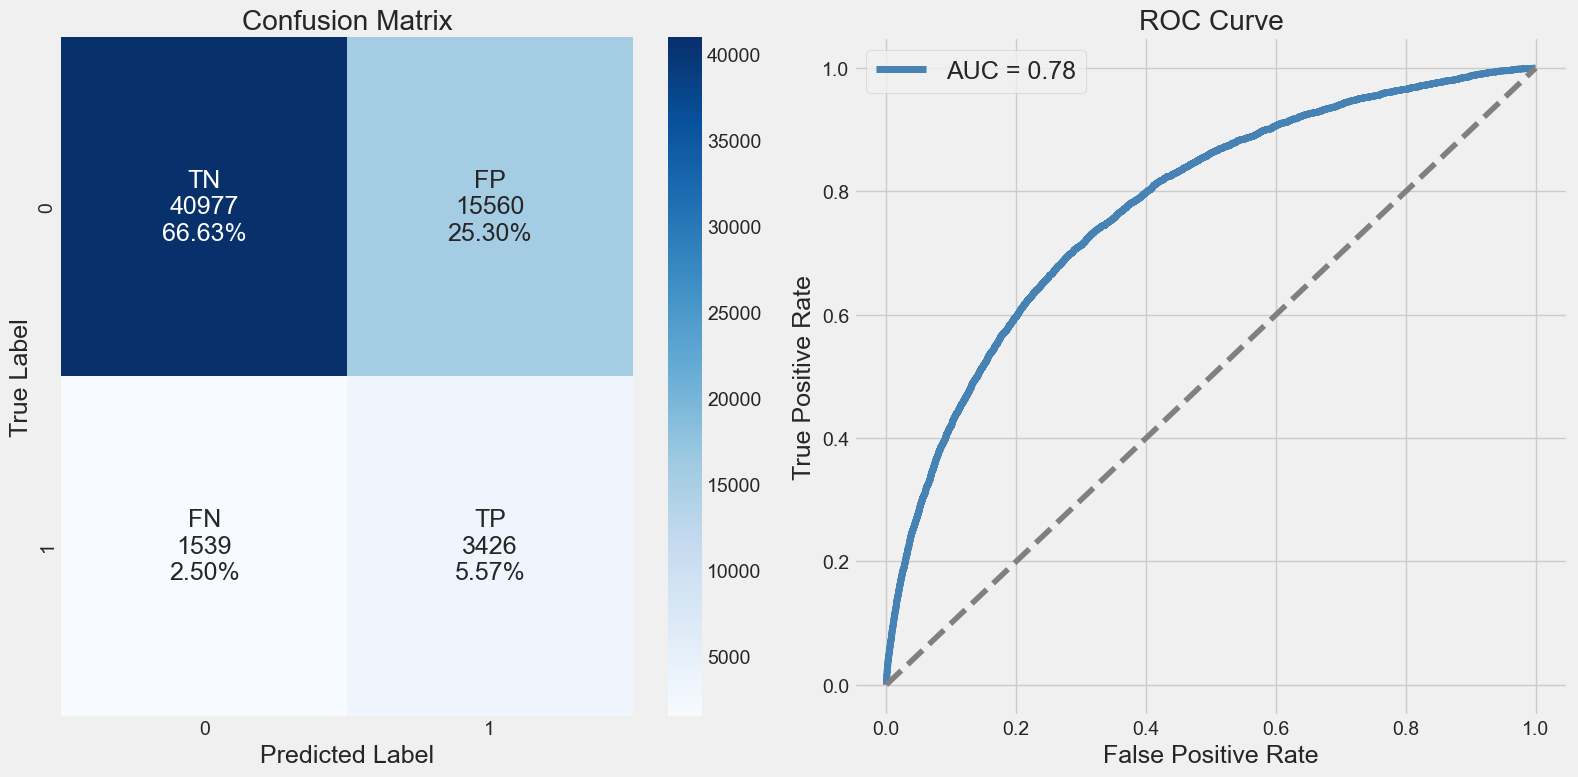

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_balanced      0.72       0.18    0.69      0.29           0.78   

   custom_score  execution_time  
0          0.71          15.325

In [77]:
model = LGBMClassifier(class_weight="balanced", random_state=42)
lgbm_balanced, results_lgbm_balanced = mlfow_track("lgbm_balanced", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "lgbm_balanced", (16,8))

# LGBM Class weigth balanced avec 10 features selectionnés

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.69      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.69      0.54     61502
weighted avg       0.90      0.70      0.77     61502



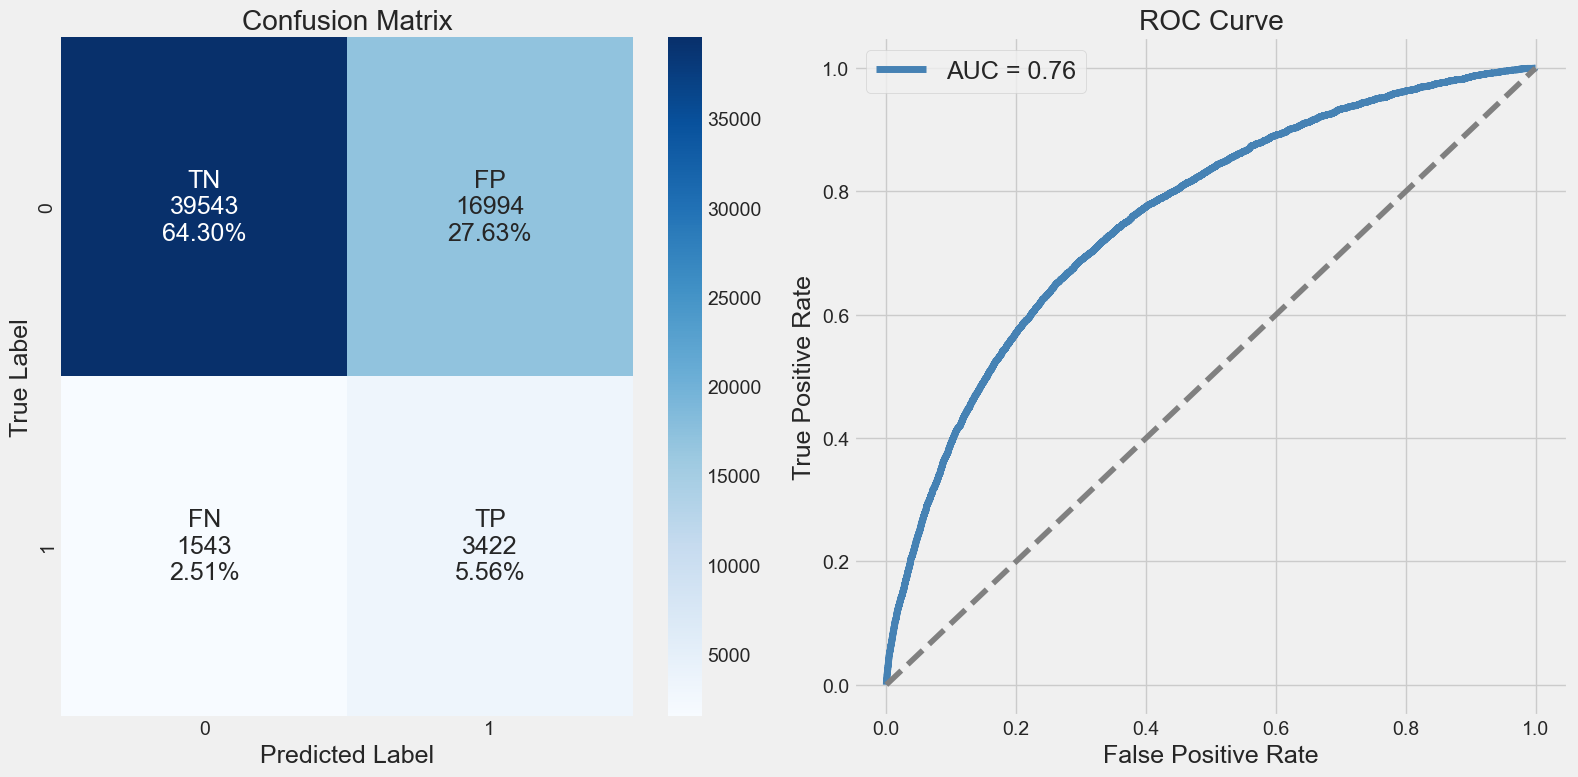

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_imp       0.7       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0          0.69            2.16

In [114]:
model = LGBMClassifier(class_weight="balanced", random_state=42)
lgbm_imp, results_lgbm_imp = mlfow_track("lgbm_imp", model,
                             X_train_imp, y_train, X_test_imp, y_test, "lgbm_imp", (16,8))

In [115]:
results_lgbm_balanced

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_balanced      0.72       0.18    0.69      0.29           0.78   

   custom_score  execution_time  
0          0.71          14.652

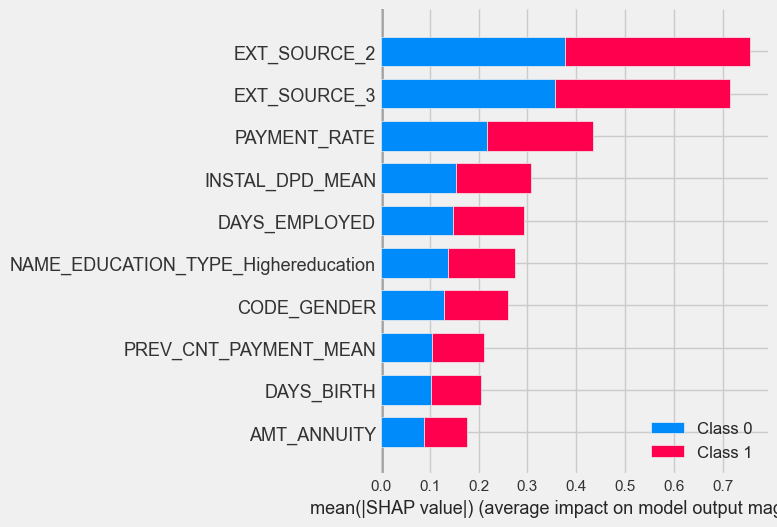

In [116]:
# Explain model predictions using shap library:
model = lgbm_imp
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_imp)
# Plot summary_plot
shap.summary_plot(shap_values, X_test_imp)

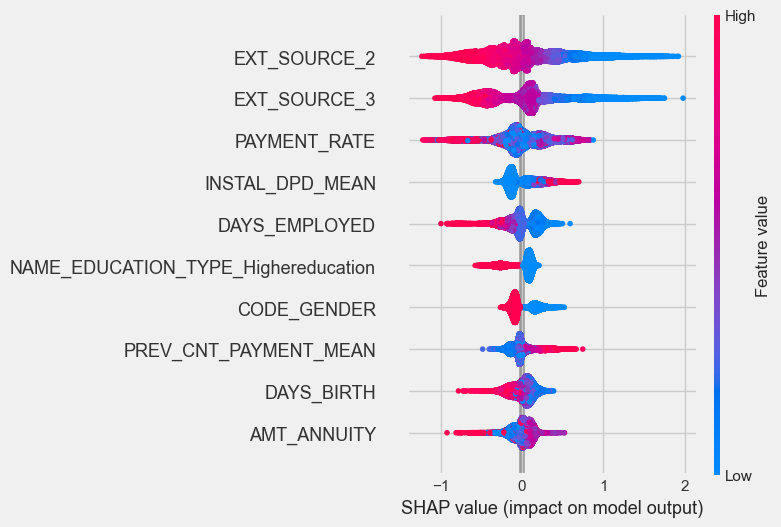

In [117]:
shap.summary_plot(shap_values[1], X_test_imp, feature_names=X_test_imp.columns)

In [119]:
X_test_sample2 = X_test_imp.head(1)
X_test_sample2

EXT_SOURCE_2  EXT_SOURCE_3  CODE_GENDER  PAYMENT_RATE  \
SK_ID_CURR                                                          
343913          0.030433      0.118993     0.720924     -0.241825   

            DAYS_EMPLOYED  INSTAL_DPD_MEAN  PREV_CNT_PAYMENT_MEAN  \
SK_ID_CURR                                                          
343913          -0.282717        -0.052077              -0.290348   

            NAME_EDUCATION_TYPE_Highereducation  DAYS_BIRTH  AMT_ANNUITY  
SK_ID_CURR                                                                
343913                                  1.76257    0.991715     0.644464

### Shap pour X_test_sample2

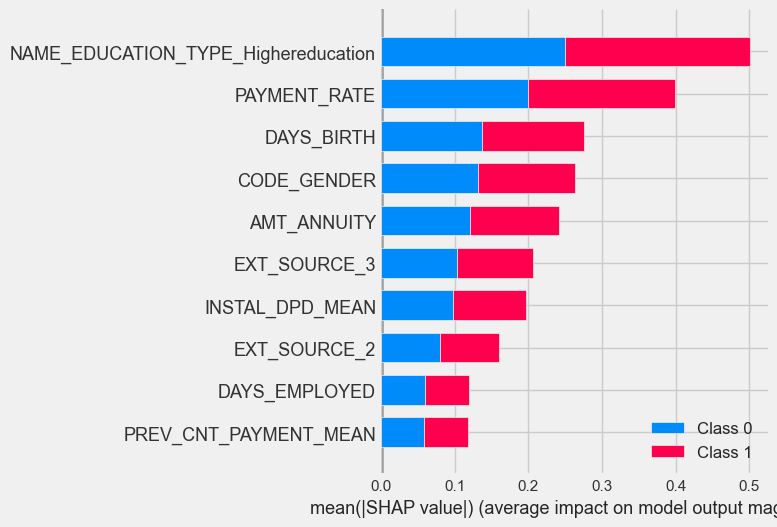

In [120]:
# Explain model predictions using shap library:
model = lgbm_imp
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample2)
# Plot summary_plot
shap.summary_plot(shap_values, X_test_sample2)

In [121]:
model = lgbm_imp
subsampled_test_data =X_test_sample2

# explain first sample from test data
start_time = time.time()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(subsampled_test_data)
elapsed_time = time.time() - start_time

print("Tree Explainer SHAP run time", round(elapsed_time,3) , " seconds. ", "lgbm_balanced")
print("SHAP expected value", explainer.expected_value)
print("Model prediction for test data", model.predict_proba(subsampled_test_data))
shap.initjs()
pred_ind = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][0], subsampled_test_data.iloc[0], 
                feature_names=X_test_sample2.columns)

Tree Explainer SHAP run time 0.068  seconds.  lgbm_balanced
SHAP expected value [0.4390451030510937, -0.4390451030510937]
Model prediction for test data [[0.61669374 0.38330626]]


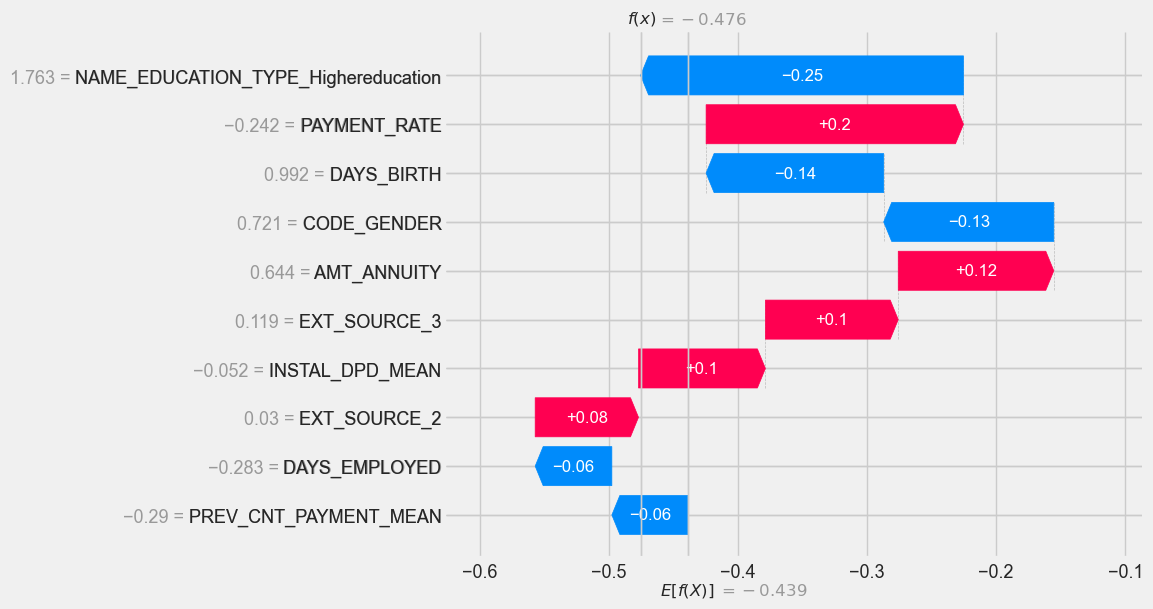

In [122]:
# Explain model predictions using shap library:
model = lgbm_imp
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample2)
shap.waterfall_plot(explainer(X_test_sample2)[0][:,1])

In [260]:
X_test_sample2

EXT_SOURCE_2  EXT_SOURCE_3  CODE_GENDER  PAYMENT_RATE  \
SK_ID_CURR                                                          
343913          0.030433      0.118993     0.720924     -0.241825   

            DAYS_EMPLOYED  INSTAL_DPD_MEAN  PREV_CNT_PAYMENT_MEAN  \
SK_ID_CURR                                                          
343913          -0.282717        -0.052077              -0.290348   

            NAME_EDUCATION_TYPE_Highereducation  DAYS_BIRTH  AMT_ANNUITY  
SK_ID_CURR                                                                
343913                                  1.76257    0.991715     0.644464

In [261]:
client_data_json_new = '[{"EXT_SOURCE_2":0.0304315707,"EXT_SOURCE_3":0.1107962886,"CODE_GENDER":0.7209239877,"PAYMENT_RATE":-0.2418253653,"DAYS_EMPLOYED":-0.2827170179,"INSTAL_DPD_MEAN":-0.052079095,"PREV_CNT_PAYMENT_MEAN":-0.2903476431,"NAME_EDUCATION_TYPE_Highereducation":1.7625702765,"DAYS_BIRTH":0.9917147317,"AMT_ANNUITY":0.6444642056}]'

In [258]:
model = lgbm_imp
prediction2 = model.predict_proba(X_test_sample2)[0][1].round(2)
prediction2

0.38

In [259]:
model = best_model
prediction1 = model.predict_proba(X_test_sample2)[0][1].round(2)
prediction1

0.37

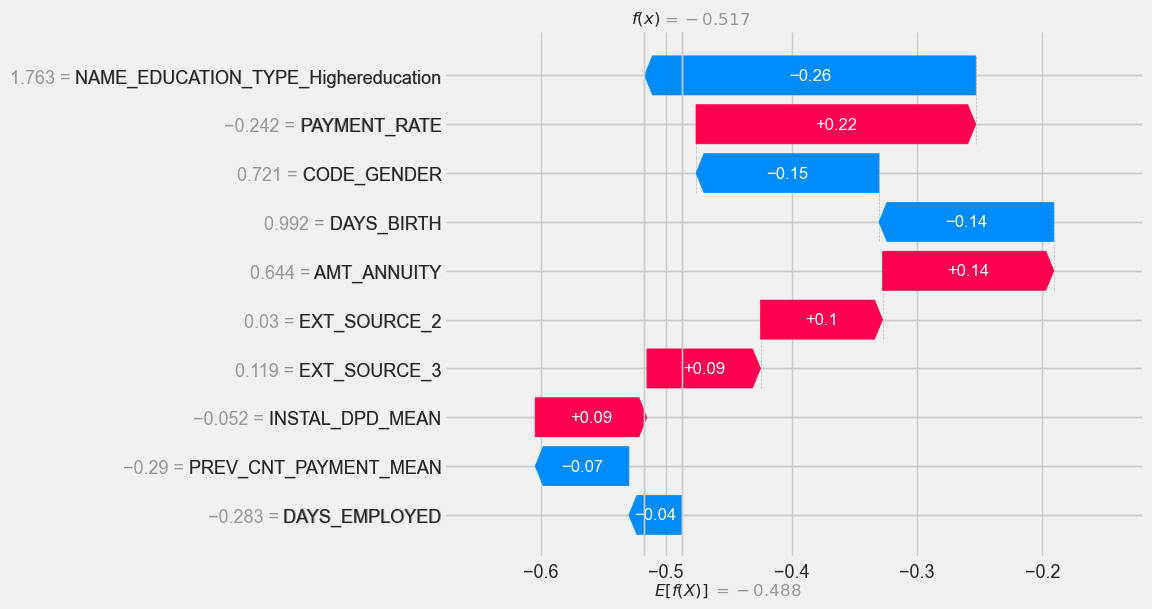

In [256]:
# Explain model predictions using shap library:
model = best_model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample2)
shap.waterfall_plot(explainer(X_test_sample2)[0][:,1])

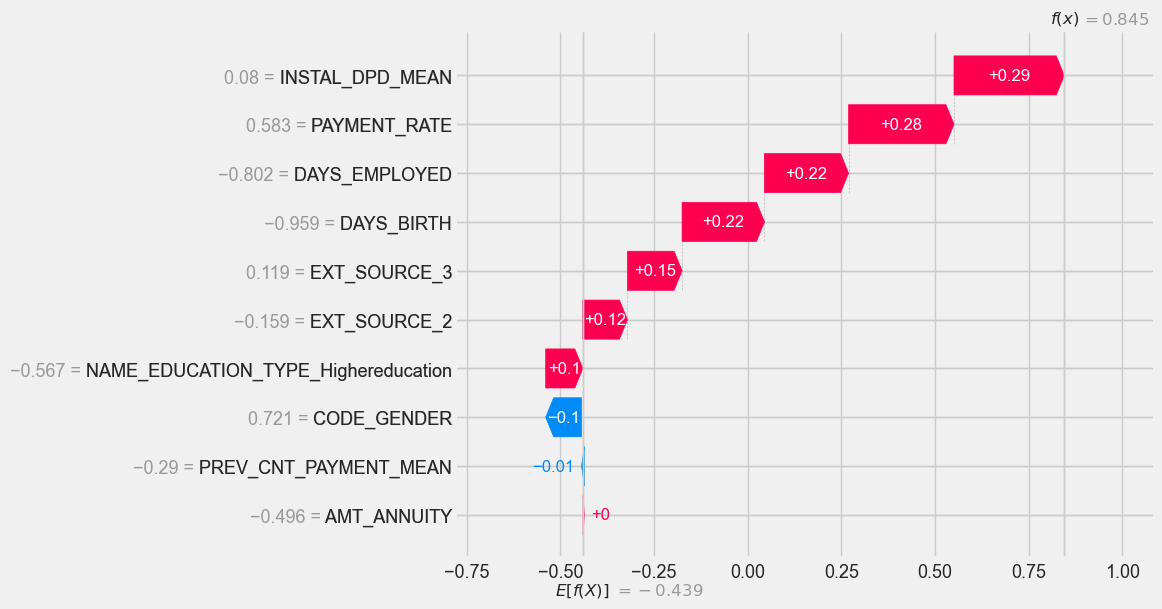

In [123]:
# Explain model predictions using shap library:
model = lgbm_imp
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_imp)
shap.waterfall_plot(explainer(X_test_imp)[2][:,1])

In [125]:
X_test_imp

EXT_SOURCE_2  EXT_SOURCE_3  CODE_GENDER  PAYMENT_RATE  \
SK_ID_CURR                                                          
343913          0.030433      0.118993     0.720924     -0.241825   
281768          0.360033      0.883285     0.720924     -1.082975   
215345         -0.158852      0.118993     0.720924      0.582748   
421739         -2.016620      1.459499     0.720924      1.950712   
408896         -2.114699     -0.686886     0.720924     -0.215425   
...                  ...           ...          ...           ...   
203309          0.417801      0.772336     0.720924      1.725840   
388535         -1.080894      1.260740     0.720924     -0.913221   
405439          0.182562      0.522289     0.720924     -1.081998   
322531          0.406540     -2.660184     0.720924     -1.161736   
227354         -0.085103     -1.413141     0.720924     -0.791426   

            DAYS_EMPLOYED  INSTAL_DPD_MEAN  PREV_CNT_PAYMENT_MEAN  \
SK_ID_CURR                                                          
343913          -0.282717        -0.052077              -0.290348   
281768          -0.345732        -0.110735               1.175612   
215345          -0.802166         0.079901              -0.290348   
421739          -0.282717        -0.110735              -1.186212   
408896          -0.282717        -0.110735               1.200045   
...                   ...              ...                    ...   
203309           0.871992        -0.106537              -0.290348   
388535          -0.919680        -0.110735              -0.534674   
405439          -0.209483        -0.110735               0.686959   
322531          -0.226514        -0.082044              -0.351429   
227354          -0.282717        -0.104624               1.943496   

            NAME_EDUCATION_TYPE_Highereducation  DAYS_BIRTH  AMT_ANNUITY  
SK_ID_CURR                                                                
343913                                 1.762570    0.991715     0.644464  
281768                                -0.567353   -0.979982     0.320462  
215345                                -0.567353   -0.959078    -0.496384  
421739                                -0.567353    1.697445     2.889159  
408896                                -0.567353    1.592924    -1.310432  
...                                         ...         ...          ...  
203309                                 1.762570    0.161394    -0.436061  
388535                                -0.567353   -1.701600     0.515112  
405439                                -0.567353   -0.012530     0.029420  
322531                                 1.762570   -1.050221     1.058640  
227354                                -0.567353    1.168147    -0.927973  

[61502 rows x 10 columns]

In [83]:
data_test_imp = X_test_imp.reset_index()
data_test_imp.SK_ID_CURR = data_test_imp.SK_ID_CURR.astype(int)
data_test_imp.head(2)

SK_ID_CURR  EXT_SOURCE_2  EXT_SOURCE_3  CODE_GENDER  PAYMENT_RATE  \
0      343913      0.030433      0.118993     0.720924     -0.241825   
1      281768      0.360033      0.883285     0.720924     -1.082975   

   DAYS_EMPLOYED  INSTAL_DPD_MEAN  PREV_CNT_PAYMENT_MEAN  \
0      -0.282717        -0.052077              -0.290348   
1      -0.345732        -0.110735               1.175612   

   NAME_EDUCATION_TYPE_Highereducation  DAYS_BIRTH  AMT_ANNUITY  
0                             1.762570    0.991715     0.644464  
1                            -0.567353   -0.979982     0.320462

In [128]:
#data_test_imp = data_test_imp.to_csv("data_test_imp.csv", index=False)

# Gridsearch Model hyperparametre Tuning

In [126]:
params = {'n_estimators' : [100, 350, 500],
          
          'learning_rate': [0.05, 0.1, 0.2, 0.3]
         }

mlflow.lightgbm.autolog()
with mlflow.start_run(run_name='Grid_lgbm'):
    model = LGBMClassifier(class_weight="balanced", random_state=42)
    grid_lgbm = GridSearchCV(
        model,
        param_grid=params,
        cv=5,
        scoring="roc_auc",
        return_train_score=True)
    
    grid_lgbm.fit(X_train_imp, y_train)

2023/10/05 13:37:47 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


In [128]:
result_lgbm = pd.DataFrame(grid_lgbm.cv_results_)
result_lgbm.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.668813      0.169656         0.060999        0.004473   
1       1.078921      0.057054         0.115250        0.003063   
2       1.460067      0.087809         0.138504        0.003409   
3       0.383659      0.009103         0.047486        0.001494   
4       1.080392      0.081455         0.088691        0.002763   

  param_learning_rate param_n_estimators  \
0                0.05                100   
1                0.05                350   
2                0.05                500   
3                 0.1                100   
4                 0.1                350   

                                         params  split0_test_score  \
0  {'learning_rate': 0.05, 'n_estimators': 100}           0.754758   
1  {'learning_rate': 0.05, 'n_estimators': 350}           0.757280   
2  {'learning_rate': 0.05, 'n_estimators': 500}           0.756024   
3   {'learning_rate': 0.1, 'n_estimators': 100}           0.757422   
4   {'learning_rate': 0.1, 'n_estimators': 350}           0.752446   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.758039           0.749028           0.752422           0.747834   
1           0.759331           0.751537           0.754679           0.752285   
2           0.758695           0.750226           0.754184           0.750868   
3           0.758713           0.751556           0.754273           0.750864   
4           0.755157           0.748173           0.750254           0.747512   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.752416        0.003730                4            0.772319   
1         0.755022        0.002947                1            0.810083   
2         0.754000        0.003170                3            0.826096   
3         0.754566        0.003105                2            0.790800   
4         0.750709        0.002816                6            0.844552   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.772007            0.773146            0.772933   
1            0.808808            0.810326            0.810920   
2            0.824935            0.827095            0.827843   
3            0.789735            0.790905            0.790556   
4            0.844422            0.846289            0.845525   

   split4_train_score  mean_train_score  std_train_score  
0            0.773654          0.772812         0.000587  
1            0.810708          0.810169         0.000740  
2            0.826545          0.826503         0.000977  
3            0.790470          0.790493         0.000411  
4            0.845089          0.845176         0.000682

In [129]:
 # Obtenir les meilleurs hyperparamètres et le meilleur modèle
best_params = grid_lgbm.best_params_
best_model = grid_lgbm.best_estimator_

In [130]:
best_params

{'learning_rate': 0.05, 'n_estimators': 350}

In [131]:
best_model

LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=350,
               random_state=42)

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.68      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.69      0.54     61502
weighted avg       0.90      0.70      0.77     61502



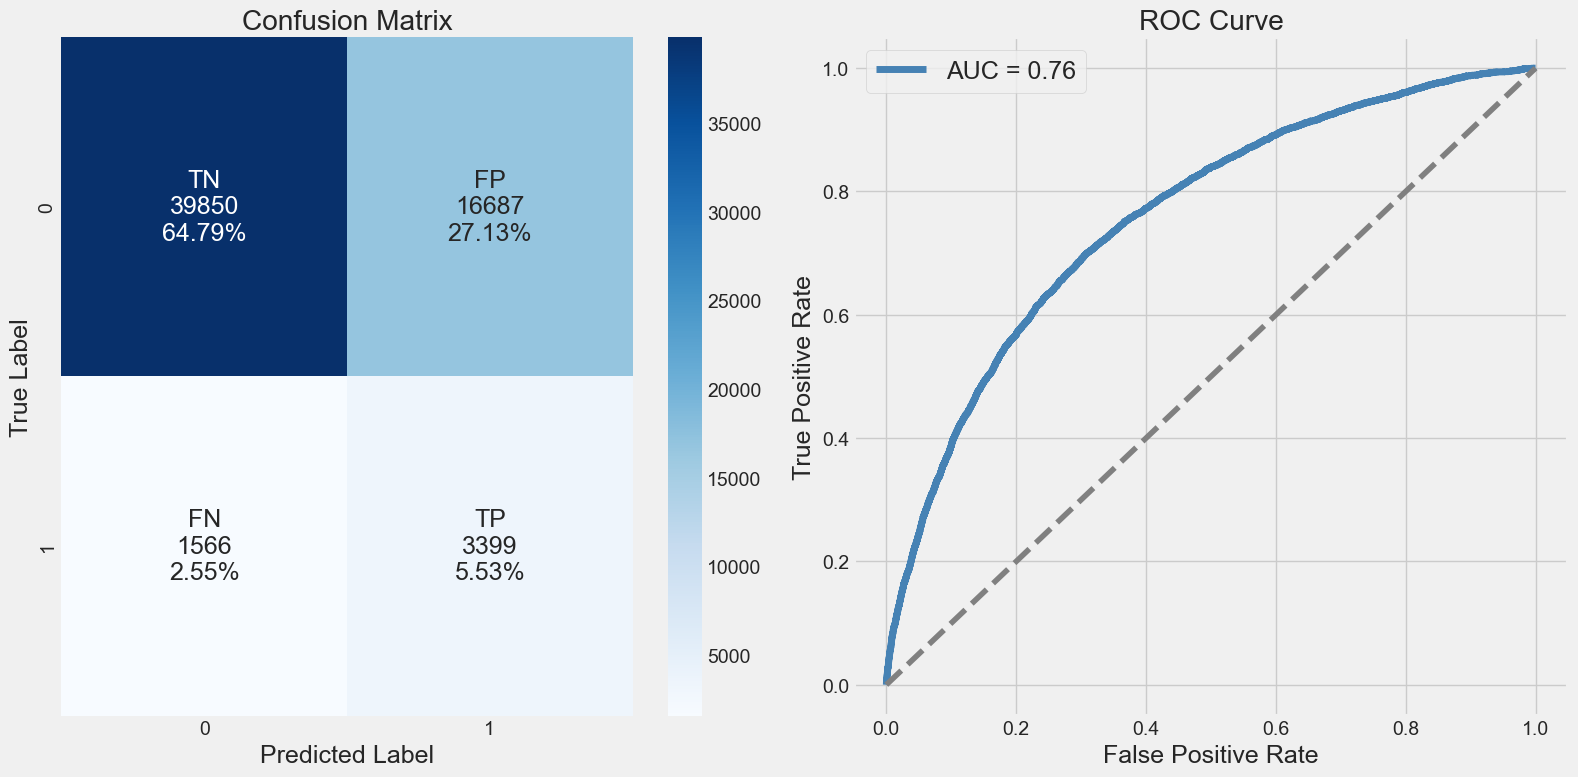

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_imp_grid       0.7       0.17    0.68      0.27           0.76   

   custom_score  execution_time  
0           0.7           3.186

In [132]:
model = best_model
lgbm_imp_grid, results_lgbm_imp_grid = mlfow_track("lgbm_imp_grid", model,
                             X_train_imp, y_train, X_test_imp, y_test, "lgbm_imp_grid", (16,8))

# Seuil score metier

In [152]:
def threshold_optimum(model, X_test, y_test):

    #y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    scores = []
    for threshold in np.arange(0, 1.1, 0.01):
        y_pred = np.where(y_pred_proba > threshold, 1, 0)
        score = fonction_metier(y_test, y_pred)
        scores.append(score)


    score_max = max(scores)
    threshold_optimum = np.arange(0, 1.1, 0.01)[scores.index(score_max)]
    y_pred = np.where(y_pred_proba > threshold_optimum, 1, 0)
    
    print("Max custom score : ", score_max.round(2))
    print("Threshold optimum : ", threshold_optimum)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(np.arange(0, 1.1, 0.01), scores, label="model score")
    plt.axvline(x=threshold_optimum, color='r', dashes=(0.1, 2), 
                label="Threshold optimum: {}".format(threshold_optimum))
    plt.title("Custom score vs threshold", fontsize=10)
    plt.xlabel("Thresholds", fontsize=10)
    plt.ylabel("Custom score", fontsize=10)
    
    plt.legend()
    plt.show()
     

Max custom score :  0.7
Threshold optimum :  0.54


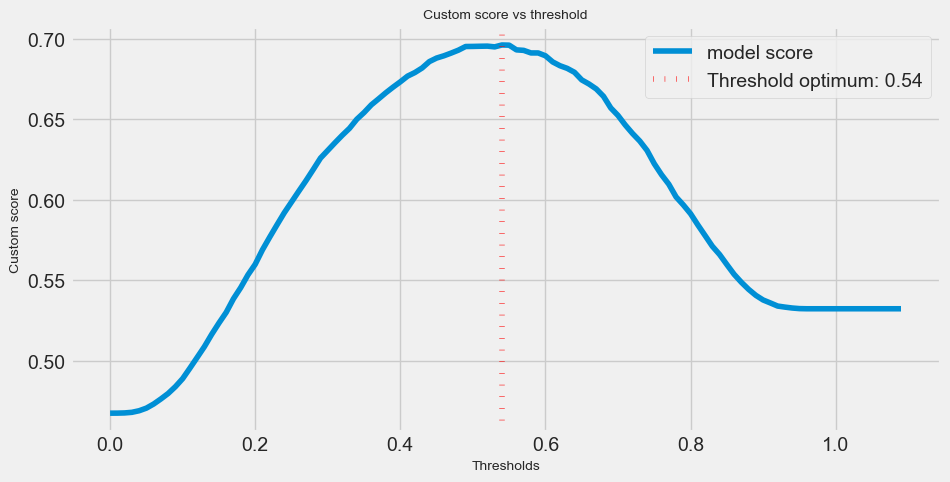

In [153]:
threshold_optimum(best_model, X_test_imp, y_test)

In [154]:
y_pred_proba = model.predict_proba(X_test_imp)[:, 1]
y_pred_proba

array([0.37347189, 0.35512508, 0.69261857, ..., 0.30390449, 0.66113648,
       0.54363716])

In [155]:
y_pred_default = np.where(y_pred_proba > 0.5, 1, 0)

In [156]:
y_pred_default

array([0, 0, 1, ..., 0, 1, 1])

In [157]:
Counter(y_pred_default)

Counter({0: 41416, 1: 20086})

In [158]:
df = pd.DataFrame({'Values': y_pred_default})


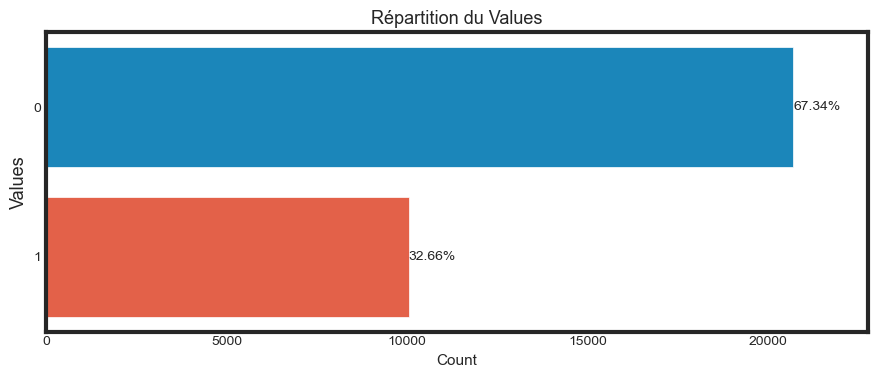

In [159]:
functions.countplot(df, "Values", figsize=(9, 4))

In [160]:
y_pred_optimum = np.where(y_pred_proba > 0.54, 1, 0)

In [161]:
df2 = pd.DataFrame({'Values': y_pred_optimum})

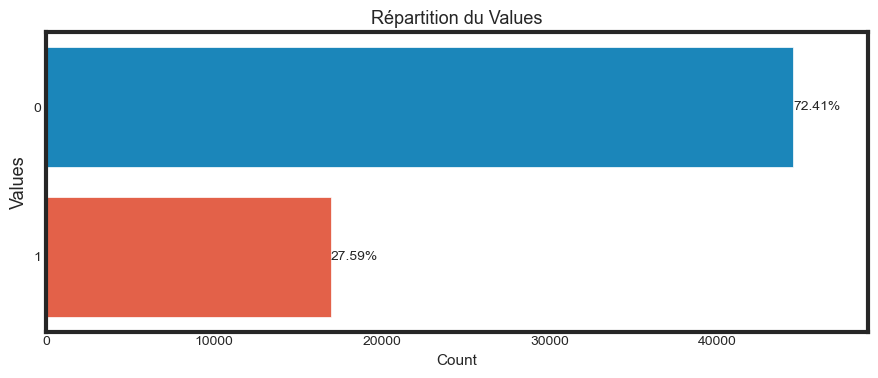

In [162]:
functions.countplot(df2, "Values", figsize=(9, 4))

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
import time

def evaluation_score_threshold(model, X_train, y_train, X_test, y_test, model_name, figsize, custom_threshold=None):
    '''
    Calculate, display, and save different metrics.

    :param model: The machine learning model to evaluate.
    :param X_train: Training data.
    :param y_train: Target labels for training data.
    :param X_test: Testing data.
    :param y_test: True labels for testing data.
    :param figsize: Tuple specifying the figure size for ROC curve.
    :param model_name: Name of the model (for result DataFrame).
    :param custom_threshold: Optional custom threshold for binary predictions (default is 0.5).
    :return: A DataFrame with metrics.
    '''
    start_time = time.time()
    model.fit(X_train, y_train)
    execution_time = time.time() - start_time
    execution_time = round(execution_time, 3)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    if custom_threshold is not None:
        # Use the custom threshold for binary predictions
        y_pred = np.where(y_pred_proba > custom_threshold, 1, 0)
    
    metier = fonction_metier(y_test, y_pred).round(2)
    accuracy = metrics.accuracy_score(y_test, y_pred).round(2)
    precision = metrics.precision_score(y_test, y_pred).round(2)
    recall = metrics.recall_score(y_test, y_pred).round(2)
    f1_score = metrics.f1_score(y_test, y_pred).round(2)
    auc_score = metrics.roc_auc_score(y_test, y_pred_proba).round(2)

    # Display classification report
    print(classification_report(y_test, y_pred))

    # Display confusion matrix and ROC curve
    conf_matrix_roc_curve(y_test, y_pred, y_pred_proba, figsize)

    # Create a DataFrame with rounded metrics
    results = pd.DataFrame({'model': [model_name],
                            'accuracy': [accuracy],
                            'precision': [precision],
                            'recall': [recall],
                            'f1_score': [f1_score],
                            'roc_auc_score': [auc_score],
                            'custom_score': [metier],
                            'execution_time': [execution_time]})
  

    return results, precision, recall, f1_score, auc_score, metier


In [122]:
def mlfow_track_threshold(exp_name, model, X_train, y_train, X_test, y_test, model_name, figsize,
                          custom_threshold):
    model = model
    signature = infer_signature(X_train, y_train)
    plt.style.use('fivethirtyeight')
    mlflow.set_experiment(exp_name)
    mlflow.sklearn.autolog()
    mlflow.lightgbm.autolog()
    with mlflow.start_run(run_name=exp_name):
        model.fit(X_train, y_train)
        results, precision, recall, f1_score, auc_score,\
        metier = evaluation_score_threshold(model, X_train, y_train, X_test, y_test, model_name, figsize,
                                           custom_threshold=custom_threshold) 
        #mlflow.log_param("class_weight", class_weight)
        #mlflow.log_param("max_iter", max_iter)
        mlflow.log_metric("custom_score", metier)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1_score)
        mlflow.log_metric("rocauc", auc_score)
        #mlflow.sklearn.log_model(model, "model", registered_model_name=model_name, signature=signature)
        #mlflow.lightgbm.log_model(model, "model", registered_model_name=model_name, signature=signature)
    return model, results

In [124]:
best_model, results_threshold_best_model = mlfow_track_threshold("threshold_best_model",
                                                                 best_model, X_train_imp, y_train, X_test_imp,
                      y_test, "threshold_best_model", (16,8), 0.54)

NameError: name 'best_model' is not defined

In [174]:
results_threshold_best_model

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  threshold_best_model      0.74       0.18    0.63      0.28           0.76   

   custom_score  execution_time  
0           0.7           3.762

In [175]:
results_lgbm_imp_grid

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_imp_grid       0.7       0.17    0.68      0.27           0.76   

   custom_score  execution_time  
0           0.7           2.926

# Preparation des datasets et pipelines pour api et dashboard

In [78]:
app_train = pd.read_csv("data_p7/application_train.csv")
app_train.head(2)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  \
0                       0                        0  Business Entity Type 3   
1                       0                        0                  School   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960          0.0605   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0           0.00         0.0690         0.0833         0.1250        0.0369   
1           0.08         0.0345         0.2917         0.3333        0.0130   

   LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
0                0.0202          0.0190                   0.0000   
1                0.0773          0.0549                   0.0039   

   NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  \
0             0.0000           0.0252             0.0383   
1             0.0098           0.0924             0.0538   

   YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  \
0                        0.9722            0.6341           0.0144   
1                        0.9851            0.8040           0.0497   

   ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  FLOORSMIN_MODE  \
0          0.0000          0.0690          0.0833          0.1250   
1          0.0806          0.0345          0.2917          0.3333   

   LANDAREA_MODE  

In [79]:
app_train = app_train[app_train['CODE_GENDER'] != 'XNA']

In [80]:
app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

In [81]:
app_train.DAYS_BIRTH = (app_train.DAYS_BIRTH / -365).round()
app_train.DAYS_EMPLOYED = (app_train.DAYS_EMPLOYED / -365).round()

In [84]:
# Assuming df1 and df2 are your dataframes with ID columns
matching_ids = data_test_imp['SK_ID_CURR'].tolist()
filtered_data = app_train[app_train['SK_ID_CURR'].isin(matching_ids)]
filtered_data.shape

(61502, 122)

In [85]:
filtered_data.head(2)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
5       100008       0         Cash loans           M            N   
11      100015       0         Cash loans           F            N   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
5                Y             0         99000.000    490495.5      27517.5   
11               Y             0         38419.155    148365.0      10678.5   

    AMT_GOODS_PRICE  NAME_TYPE_SUITE NAME_INCOME_TYPE  \
5          454500.0  Spouse, partner    State servant   
11         135000.0         Children        Pensioner   

              NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
5   Secondary / secondary special            Married  House / apartment   
11  Secondary / secondary special            Married  House / apartment   

    REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
5                     0.035792        46.0            4.0            -4970.0   
11                    0.015221        56.0            NaN            -5246.0   

    DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
5              -477          NaN           1               1                1   
11            -2512          NaN           1               0                0   

    FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
5                  1           1           0        Laborers              2.0   
11                 1           1           0             NaN              2.0   

    REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
5                      2                            2   
11                     2                            2   

   WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
5                   WEDNESDAY                       16   
11                     FRIDAY                        7   

    REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
5                            0                           0   
11                           0                           0   

    LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
5                             0                       0   
11                            0                       0   

    REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY ORGANIZATION_TYPE  \
5                        0                        0             Other   
11                       0                        0               XNA   

    EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  \
5            NaN      0.354225      0.621226             NaN   
11      0.722044      0.555183      0.652897             NaN   

    BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  \
5                NaN                          NaN              NaN   
11               NaN                          NaN              NaN   

    COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
5              NaN            NaN            NaN            NaN   
11             NaN            NaN            NaN            NaN   

    FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
5             NaN           NaN                   NaN             NaN   
11            NaN           NaN                   NaN             NaN   

    NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
5                       NaN                NaN              NaN   
11                      NaN                NaN              NaN   

    BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
5                 NaN                           NaN               NaN   
11                NaN                           NaN               NaN   

    COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  \
5               NaN             NaN             NaN             NaN   
11              NaN             NaN             NaN             NaN   

    FLOORSMIN_MODE  LANDAREA_MODE 

In [190]:
#filtered_data.to_csv("filtered_data.csv", index=False)

# Data pour comparaison voisins

In [86]:
cols_prep = ['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CODE_GENDER',
 'PAYMENT_RATE',
 'DAYS_EMPLOYED',
 'INSTAL_DPD_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'NAME_EDUCATION_TYPE_Highereducation',
 'DAYS_BIRTH',
 'AMT_ANNUITY', 'TARGET']

In [87]:
df_X_train_scaled = X_train_scaled.copy()
df_X_train_scaled["TARGET"] = y_train

In [89]:
data_knn = df_X_train_scaled[cols_prep ]
data_knn_sample = data_knn.sample(10000, random_state=42)
#data_knn_sample.to_csv("data_knn_sample.csv")

## On va entrainer imputer et scaler avec 10 features

In [90]:
X_train2 = X_train_null[cols_importance]
X_train2.shape

(246005, 10)

In [91]:
X_test2 = X_test_null[cols_importance]
X_test2.shape

(61502, 10)

In [92]:
X_test2.head(2)

EXT_SOURCE_2  EXT_SOURCE_3  CODE_GENDER  PAYMENT_RATE  \
SK_ID_CURR                                                          
343913          0.520273           NaN            1      0.048278   
281768          0.583140      0.670652            1      0.029356   

            DAYS_EMPLOYED  INSTAL_DPD_MEAN  PREV_CNT_PAYMENT_MEAN  \
SK_ID_CURR                                                          
343913                NaN         0.533333                   12.0   
281768               4.15         0.000000                   24.0   

            NAME_EDUCATION_TYPE_Highereducation  DAYS_BIRTH  AMT_ANNUITY  
SK_ID_CURR                                                                
343913                                        1       55.80      36459.0  
281768                                        0       32.22      31770.0

In [93]:
X_test2.isnull().sum()

EXT_SOURCE_2                             117
EXT_SOURCE_3                           12075
CODE_GENDER                                0
PAYMENT_RATE                               0
DAYS_EMPLOYED                          11124
INSTAL_DPD_MEAN                         3124
PREV_CNT_PAYMENT_MEAN                   3306
NAME_EDUCATION_TYPE_Highereducation        0
DAYS_BIRTH                                 0
AMT_ANNUITY                                0
dtype: int64

In [108]:
data_for_test = X_test2.reset_index()
data_for_test.SK_ID_CURR = data_for_test.SK_ID_CURR.astype(int)
data_for_test.head(2)

SK_ID_CURR  EXT_SOURCE_2  EXT_SOURCE_3  CODE_GENDER  PAYMENT_RATE  \
0      343913      0.520273           NaN            1      0.048278   
1      281768      0.583140      0.670652            1      0.029356   

   DAYS_EMPLOYED  INSTAL_DPD_MEAN  PREV_CNT_PAYMENT_MEAN  \
0            NaN         0.533333                   12.0   
1           4.15         0.000000                   24.0   

   NAME_EDUCATION_TYPE_Highereducation  DAYS_BIRTH  AMT_ANNUITY  
0                                    1       55.80      36459.0  
1                                    0       32.22      31770.0

In [109]:
#data_for_test.to_csv("data_for_test.csv", index=False)

In [147]:
data_test_sample = data_for_test[0:10000]
data_test_sample

SK_ID_CURR  EXT_SOURCE_2  EXT_SOURCE_3  CODE_GENDER  PAYMENT_RATE  \
0         343913      0.520273           NaN            1      0.048278   
1         281768      0.583140      0.670652            1      0.029356   
2         215345      0.484170           NaN            1      0.066826   
3         421739      0.129826      0.771362            1      0.097598   
4         408896      0.111119      0.396220            1      0.048872   
...          ...           ...           ...          ...           ...   
9995      148845      0.030520      0.124519            1      0.038936   
9996      351475      0.330215      0.709189            0      0.056086   
9997      124900      0.523394      0.657784            1      0.032378   
9998      335707      0.765404           NaN            1      0.052963   
9999      148400      0.563112      0.389339            1      0.050000   

      DAYS_EMPLOYED  INSTAL_DPD_MEAN  PREV_CNT_PAYMENT_MEAN  \
0               NaN         0.533333              12.000000   
1              4.15         0.000000              24.000000   
2              1.47         1.733333              12.000000   
3               NaN         0.000000               4.666667   
4               NaN         0.000000              24.200000   
...             ...              ...                    ...   
9995           3.62         0.022727              27.666667   
9996           9.15         0.000000               7.333333   
9997           1.50         1.563953              12.000000   
9998           3.10         0.000000               6.000000   
9999           3.22         1.333333              12.000000   

      NAME_EDUCATION_TYPE_Highereducation  DAYS_BIRTH  AMT_ANNUITY  
0                                       1       55.80      36459.0  
1                                       0       32.22      31770.0  
2                                       0       32.47      19948.5  
3                                       0       64.24      68944.5  
4                                       0       62.99       8167.5  
...                                   ...         ...          ...  
9995                                    0       38.19      26905.5  
9996                                    0       33.10      29529.0  
9997                                    0       53.40      35541.0  
9998                                    1       45.33      11421.0  
9999                                    1       59.35      16875.0  

[10000 rows x 11 columns]

In [148]:
#data_test_sample.to_csv("data_test_sample.csv", index=False)

# Data pour info clients 

In [149]:
app_train = pd.read_csv("data_p7/application_train.csv")
app_train.head(2)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  \
0                       0                        0  Business Entity Type 3   
1                       0                        0                  School   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960          0.0605   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0           0.00         0.0690         0.0833         0.1250        0.0369   
1           0.08         0.0345         0.2917         0.3333        0.0130   

   LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
0                0.0202          0.0190                   0.0000   
1                0.0773          0.0549                   0.0039   

   NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  \
0             0.0000           0.0252             0.0383   
1             0.0098           0.0924             0.0538   

   YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  \
0                        0.9722            0.6341           0.0144   
1                        0.9851            0.8040           0.0497   

   ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  FLOORSMIN_MODE  \
0          0.0000          0.0690          0.0833          0.1250   
1          0.0806          0.0345          0.2917          0.3333   

   LANDAREA_MODE  

In [150]:
app_train = app_train[app_train['CODE_GENDER'] != 'XNA']

In [151]:
app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

In [152]:
app_train.DAYS_BIRTH = (app_train.DAYS_BIRTH / -365).round()
app_train.DAYS_EMPLOYED = (app_train.DAYS_EMPLOYED / -365).round()

In [153]:
# Assuming df1 and df2 are your dataframes with ID columns
matching_ids = data_test_sample['SK_ID_CURR'].tolist()
filtered_data_sample = app_train[app_train['SK_ID_CURR'].isin(matching_ids)]
filtered_data_sample.shape

(10000, 122)

In [154]:
filtered_data_sample.head(2)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
47       100054       0         Cash loans           F            N   
243      100283       0         Cash loans           F            N   

    FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
47                Y             0           99000.0    260640.0      26838.0   
243               Y             0          135000.0    747000.0      38268.0   

     AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
47          225000.0   Unaccompanied               Working   
243         747000.0   Unaccompanied  Commercial associate   

               NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
47   Secondary / secondary special            Married  House / apartment   
243  Secondary / secondary special     Civil marriage  House / apartment   

     REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
47                     0.022625        55.0           15.0            -9197.0   
243                    0.026392        34.0            2.0            -6120.0   

     DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  \
47             -3283          NaN           1               1   
243            -4734          NaN           1               1   

     FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
47                 1                 1           1           0   
243                0                 1           0           0   

    OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
47   Medicine staff              2.0                     2   
243     Sales staff              2.0                     2   

     REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
47                             2                  WEDNESDAY   
243                            2                   SATURDAY   

     HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
47                        16                           0   
243                       10                           0   

     REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
47                            0                            0   
243                           0                            0   

     REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
47                        0                       1                        1   
243                       0                       0                        0   

          ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
47   Business Entity Type 3           NaN      0.089241      0.728141   
243           Self-employed           NaN      0.653572      0.832785   

     APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
47              NaN               NaN                          NaN   
243          0.0825               NaN                       0.9737   

     YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
47               NaN             NaN            NaN            NaN   
243              NaN             NaN            0.0         0.1379   

     FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  \
47             NaN            NaN           NaN                   NaN   
243         0.1667            NaN           NaN                   NaN   

     LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  \
47              NaN                      NaN                NaN   
243          0.0644                      NaN                0.0   

     APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  \
47               NaN                NaN                           NaN   
243            0.084                NaN                        0.9737   

     YEARS_BUILD_MODE  COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  \
47                NaN              NaN             NaN             NaN   
243               NaN              NaN             0.0          0.1379 

In [155]:
#filtered_data_sample.to_csv("filtered_data_sample.csv", index=False)

# Imputer

In [96]:
from sklearn.impute import SimpleImputer
imputer2 = SimpleImputer(missing_values=np.nan, strategy="median")
X_train3 = imputer2.fit_transform(X_train2)
X_train3

array([[7.92495058e-01, 4.97468889e-01, 0.00000000e+00, ...,
        0.00000000e+00, 3.95800000e+01, 4.53330000e+04],
       [5.56360116e-01, 5.37069958e-01, 1.00000000e+00, ...,
        1.00000000e+00, 3.29500000e+01, 9.00000000e+03],
       [5.23541318e-01, 5.62060483e-01, 0.00000000e+00, ...,
        0.00000000e+00, 4.59700000e+01, 5.15430000e+04],
       ...,
       [5.26535109e-01, 7.06205110e-01, 1.00000000e+00, ...,
        0.00000000e+00, 4.94900000e+01, 3.56850000e+04],
       [1.97112821e-01, 6.21226338e-01, 1.00000000e+00, ...,
        0.00000000e+00, 2.50100000e+01, 1.80855000e+04],
       [6.19141332e-01, 5.17296581e-01, 1.00000000e+00, ...,
        0.00000000e+00, 3.75900000e+01, 2.60775000e+04]])

In [97]:
X_test3 = imputer2.transform(X_test2)
X_test3

array([[5.20272946e-01, 5.37069958e-01, 1.00000000e+00, ...,
        1.00000000e+00, 5.58000000e+01, 3.64590000e+04],
       [5.83139529e-01, 6.70651753e-01, 1.00000000e+00, ...,
        0.00000000e+00, 3.22200000e+01, 3.17700000e+04],
       [4.84169580e-01, 5.37069958e-01, 1.00000000e+00, ...,
        0.00000000e+00, 3.24700000e+01, 1.99485000e+04],
       ...,
       [5.49289356e-01, 6.07557300e-01, 1.00000000e+00, ...,
        0.00000000e+00, 4.37900000e+01, 2.75580000e+04],
       [5.92010095e-01, 5.13294139e-02, 1.00000000e+00, ...,
        1.00000000e+00, 3.13800000e+01, 4.24530000e+04],
       [4.98236084e-01, 2.69285800e-01, 1.00000000e+00, ...,
        0.00000000e+00, 5.79100000e+01, 1.37025000e+04]])

In [220]:
from sklearn.impute import SimpleImputer
imputer2 = SimpleImputer(missing_values=np.nan, strategy="median")
X_train3 = imputer2.fit_transform(X_train2)
X_train3 = pd.DataFrame(X_train3, columns=X_train2.columns, index=X_train2.index)
X_test3 = imputer2.transform(X_test2)
X_test3 = pd.DataFrame(X_test3, columns=X_test2.columns, index=X_test2.index)

In [223]:
X_test3

EXT_SOURCE_2  EXT_SOURCE_3  CODE_GENDER  PAYMENT_RATE  \
SK_ID_CURR                                                          
343913          0.520273      0.537070          1.0      0.048278   
281768          0.583140      0.670652          1.0      0.029356   
215345          0.484170      0.537070          1.0      0.066826   
421739          0.129826      0.771362          1.0      0.097598   
408896          0.111119      0.396220          1.0      0.048872   
...                  ...           ...          ...           ...   
203309          0.594158      0.651260          1.0      0.092540   
388535          0.308303      0.736623          1.0      0.033175   
405439          0.549289      0.607557          1.0      0.029378   
322531          0.592010      0.051329          1.0      0.027585   
227354          0.498236      0.269286          1.0      0.035915   

            DAYS_EMPLOYED  INSTAL_DPD_MEAN  PREV_CNT_PAYMENT_MEAN  \
SK_ID_CURR                                                          
343913               4.52         0.533333              12.000000   
281768               4.15         0.000000              24.000000   
215345               1.47         1.733333              12.000000   
421739               4.52         0.000000               4.666667   
408896               4.52         0.000000              24.200000   
...                   ...              ...                    ...   
203309              11.30         0.038168              12.000000   
388535               0.78         0.000000              10.000000   
405439               4.95         0.000000              20.000000   
322531               4.85         0.260870              11.500000   
227354               4.52         0.055556              30.285714   

            NAME_EDUCATION_TYPE_Highereducation  DAYS_BIRTH  AMT_ANNUITY  
SK_ID_CURR                                                                
343913                                      1.0       55.80      36459.0  
281768                                      0.0       32.22      31770.0  
215345                                      0.0       32.47      19948.5  
421739                                      0.0       64.24      68944.5  
408896                                      0.0       62.99       8167.5  
...                                         ...         ...          ...  
203309                                      1.0       45.87      20821.5  
388535                                      0.0       23.59      34587.0  
405439                                      0.0       43.79      27558.0  
322531                                      1.0       31.38      42453.0  
227354                                      0.0       57.91      13702.5  

[61502 rows x 10 columns]

In [105]:
import pickle

# Save the imputer to a file
with open('imputer.pkl', 'wb') as file:
    pickle.dump(imputer2, file)

# Load the imputer from the file
with open('imputer.pkl', 'rb') as file:
    loaded_imputer = pickle.load(file)

# Now you can use the loaded_imputer for imputation
#data_fillna_median = loaded_imputer.transform(dataset_removed)

# Scaler

In [99]:
scaler2 =  StandardScaler()
X_train3_s = scaler2.fit_transform(X_train3)
X_train3_s

array([[ 1.45765305, -0.10758507, -1.38710879, ..., -0.56735326,
        -0.36455876,  1.25764298],
       [ 0.21963268,  0.1189935 ,  0.72092399, ...,  1.76257028,
        -0.91894181, -1.2529077 ],
       [ 0.0475686 ,  0.26197745, -1.38710879, ..., -0.56735326,
         0.16975614,  1.68674379],
       ...,
       [ 0.0632646 ,  1.08670476,  0.72092399, ..., -0.56735326,
         0.46408923,  0.59098201],
       [-1.66384745,  0.60049646,  0.72092399, ..., -0.56735326,
        -1.58286361, -0.62511456],
       [ 0.54878526,  0.0058596 ,  0.72092399, ..., -0.56735326,
        -0.53095729, -0.07288048]])

In [101]:
X_test3_s = scaler2.transform(X_test3)
X_test3_s 

array([[ 0.03043301,  0.1189935 ,  0.72092399, ...,  1.76257028,
         0.99171473,  0.64446414],
       [ 0.36003316,  0.88328528,  0.72092399, ..., -0.56735326,
        -0.97998248,  0.32046193],
       [-0.15885157,  0.1189935 ,  0.72092399, ..., -0.56735326,
        -0.95907814, -0.49638432],
       ...,
       [ 0.18256173,  0.52228869,  0.72092399, ..., -0.56735326,
        -0.01252969,  0.02941964],
       [ 0.40654022, -2.66018392,  0.72092399, ...,  1.76257028,
        -1.05022106,  1.0586397 ],
       [-0.08510298, -1.41314067,  0.72092399, ..., -0.56735326,
         1.16814735, -0.92797267]])

In [104]:
X_test3_s_a = pd.DataFrame(X_test3_s, columns=X_test2.columns, index=X_test2.index)
X_test3_s_a

EXT_SOURCE_2  EXT_SOURCE_3  CODE_GENDER  PAYMENT_RATE  \
SK_ID_CURR                                                          
343913          0.030433      0.118993     0.720924     -0.241825   
281768          0.360033      0.883285     0.720924     -1.082975   
215345         -0.158852      0.118993     0.720924      0.582748   
421739         -2.016620      1.459499     0.720924      1.950712   
408896         -2.114699     -0.686886     0.720924     -0.215425   
...                  ...           ...          ...           ...   
203309          0.417801      0.772336     0.720924      1.725840   
388535         -1.080894      1.260740     0.720924     -0.913221   
405439          0.182562      0.522289     0.720924     -1.081998   
322531          0.406540     -2.660184     0.720924     -1.161736   
227354         -0.085103     -1.413141     0.720924     -0.791426   

            DAYS_EMPLOYED  INSTAL_DPD_MEAN  PREV_CNT_PAYMENT_MEAN  \
SK_ID_CURR                                                          
343913          -0.282717        -0.052077              -0.290348   
281768          -0.345732        -0.110735               1.175612   
215345          -0.802166         0.079901              -0.290348   
421739          -0.282717        -0.110735              -1.186212   
408896          -0.282717        -0.110735               1.200045   
...                   ...              ...                    ...   
203309           0.871992        -0.106537              -0.290348   
388535          -0.919680        -0.110735              -0.534674   
405439          -0.209483        -0.110735               0.686959   
322531          -0.226514        -0.082044              -0.351429   
227354          -0.282717        -0.104624               1.943496   

            NAME_EDUCATION_TYPE_Highereducation  DAYS_BIRTH  AMT_ANNUITY  
SK_ID_CURR                                                                
343913                                 1.762570    0.991715     0.644464  
281768                                -0.567353   -0.979982     0.320462  
215345                                -0.567353   -0.959078    -0.496384  
421739                                -0.567353    1.697445     2.889159  
408896                                -0.567353    1.592924    -1.310432  
...                                         ...         ...          ...  
203309                                 1.762570    0.161394    -0.436061  
388535                                -0.567353   -1.701600     0.515112  
405439                                -0.567353   -0.012530     0.029420  
322531                                 1.762570   -1.050221     1.058640  
227354                                -0.567353    1.168147    -0.927973  

[61502 rows x 10 columns]

In [225]:
scaler2 =  StandardScaler()
X_train3_s = scaler2.fit_transform(X_train3)
X_test3_s = scaler2.transform(X_test3)
X_train3_s = pd.DataFrame(X_train3_s, columns=X_train3.columns, index=X_train3.index)
X_test3_s = pd.DataFrame(X_test3_s, columns=X_test3.columns, index=X_test3.index)
print(X_train3_s.shape)
print(X_test3_s.shape)

(246005, 10)
(61502, 10)


In [226]:
X_test3_s

EXT_SOURCE_2  EXT_SOURCE_3  CODE_GENDER  PAYMENT_RATE  \
SK_ID_CURR                                                          
343913          0.030433      0.118993     0.720924     -0.241825   
281768          0.360033      0.883285     0.720924     -1.082975   
215345         -0.158852      0.118993     0.720924      0.582748   
421739         -2.016620      1.459499     0.720924      1.950712   
408896         -2.114699     -0.686886     0.720924     -0.215425   
...                  ...           ...          ...           ...   
203309          0.417801      0.772336     0.720924      1.725840   
388535         -1.080894      1.260740     0.720924     -0.913221   
405439          0.182562      0.522289     0.720924     -1.081998   
322531          0.406540     -2.660184     0.720924     -1.161736   
227354         -0.085103     -1.413141     0.720924     -0.791426   

            DAYS_EMPLOYED  INSTAL_DPD_MEAN  PREV_CNT_PAYMENT_MEAN  \
SK_ID_CURR                                                          
343913          -0.282717        -0.052077              -0.290348   
281768          -0.345732        -0.110735               1.175612   
215345          -0.802166         0.079901              -0.290348   
421739          -0.282717        -0.110735              -1.186212   
408896          -0.282717        -0.110735               1.200045   
...                   ...              ...                    ...   
203309           0.871992        -0.106537              -0.290348   
388535          -0.919680        -0.110735              -0.534674   
405439          -0.209483        -0.110735               0.686959   
322531          -0.226514        -0.082044              -0.351429   
227354          -0.282717        -0.104624               1.943496   

            NAME_EDUCATION_TYPE_Highereducation  DAYS_BIRTH  AMT_ANNUITY  
SK_ID_CURR                                                                
343913                                 1.762570    0.991715     0.644464  
281768                                -0.567353   -0.979982     0.320462  
215345                                -0.567353   -0.959078    -0.496384  
421739                                -0.567353    1.697445     2.889159  
408896                                -0.567353    1.592924    -1.310432  
...                                         ...         ...          ...  
203309                                 1.762570    0.161394    -0.436061  
388535                                -0.567353   -1.701600     0.515112  
405439                                -0.567353   -0.012530     0.029420  
322531                                 1.762570   -1.050221     1.058640  
227354                                -0.567353    1.168147    -0.927973  

[61502 rows x 10 columns]

In [107]:
#X_test3_s_a.to_csv("test2_imp_scale.csv")

In [106]:
import pickle

# Save the scaler2 to a file
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler2, file)

# Load the scaler2 from the file
with open('scaler.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)

# Now you can use the loaded_imputer for imputation
#data_fillna_median = loaded_imputer.transform(dataset_removed)

In [112]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='median')  
# Create an instance of StandardScaler
scaler = StandardScaler()

# Create a pipeline
pipeline_preprocess = Pipeline([
    ('imputer', imputer),    # Step 1: Impute missing values
    ('scaler', scaler)       # Step 2: Scale the features
])

# Fit and transform the training data
X_train_transformed = pipeline_preprocess.fit_transform(X_train2)

# Transform the test data using the same pipeline
X_test_transformed = pipeline_preprocess.transform(X_test2)
X_test_transformed

2023/10/05 13:05:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '77d193ede8ca4d738fcc279a39be2498', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/05 13:05:49 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/10/05 13:05:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


array([[ 0.03043301,  0.1189935 ,  0.72092399, ...,  1.76257028,
         0.99171473,  0.64446414],
       [ 0.36003316,  0.88328528,  0.72092399, ..., -0.56735326,
        -0.97998248,  0.32046193],
       [-0.15885157,  0.1189935 ,  0.72092399, ..., -0.56735326,
        -0.95907814, -0.49638432],
       ...,
       [ 0.18256173,  0.52228869,  0.72092399, ..., -0.56735326,
        -0.01252969,  0.02941964],
       [ 0.40654022, -2.66018392,  0.72092399, ...,  1.76257028,
        -1.05022106,  1.0586397 ],
       [-0.08510298, -1.41314067,  0.72092399, ..., -0.56735326,
         1.16814735, -0.92797267]])

In [113]:
X_test3_s_p = pd.DataFrame(X_test_transformed, columns=X_test2.columns, index=X_test2.index)
X_test3_s_p

EXT_SOURCE_2  EXT_SOURCE_3  CODE_GENDER  PAYMENT_RATE  \
SK_ID_CURR                                                          
343913          0.030433      0.118993     0.720924     -0.241825   
281768          0.360033      0.883285     0.720924     -1.082975   
215345         -0.158852      0.118993     0.720924      0.582748   
421739         -2.016620      1.459499     0.720924      1.950712   
408896         -2.114699     -0.686886     0.720924     -0.215425   
...                  ...           ...          ...           ...   
203309          0.417801      0.772336     0.720924      1.725840   
388535         -1.080894      1.260740     0.720924     -0.913221   
405439          0.182562      0.522289     0.720924     -1.081998   
322531          0.406540     -2.660184     0.720924     -1.161736   
227354         -0.085103     -1.413141     0.720924     -0.791426   

            DAYS_EMPLOYED  INSTAL_DPD_MEAN  PREV_CNT_PAYMENT_MEAN  \
SK_ID_CURR                                                          
343913          -0.282717        -0.052077              -0.290348   
281768          -0.345732        -0.110735               1.175612   
215345          -0.802166         0.079901              -0.290348   
421739          -0.282717        -0.110735              -1.186212   
408896          -0.282717        -0.110735               1.200045   
...                   ...              ...                    ...   
203309           0.871992        -0.106537              -0.290348   
388535          -0.919680        -0.110735              -0.534674   
405439          -0.209483        -0.110735               0.686959   
322531          -0.226514        -0.082044              -0.351429   
227354          -0.282717        -0.104624               1.943496   

            NAME_EDUCATION_TYPE_Highereducation  DAYS_BIRTH  AMT_ANNUITY  
SK_ID_CURR                                                                
343913                                 1.762570    0.991715     0.644464  
281768                                -0.567353   -0.979982     0.320462  
215345                                -0.567353   -0.959078    -0.496384  
421739                                -0.567353    1.697445     2.889159  
408896                                -0.567353    1.592924    -1.310432  
...                                         ...         ...          ...  
203309                                 1.762570    0.161394    -0.436061  
388535                                -0.567353   -1.701600     0.515112  
405439                                -0.567353   -0.012530     0.029420  
322531                                 1.762570   -1.050221     1.058640  
227354                                -0.567353    1.168147    -0.927973  

[61502 rows x 10 columns]

In [134]:
a = X_test3_s_p.head(1)

In [137]:
model = best_model
prediction3 = model.predict_proba(a)[0][1].round(2)
prediction3

0.37

In [ ]:
X_test3_s_p.head(1)

In [116]:
import pickle

# Save the imputer to a file
with open('pipeline_preprocess.pkl', 'wb') as file:
    pickle.dump(pipeline_preprocess, file)

# Load the imputer from the file
with open('pipeline_preprocess.pkl', 'rb') as file:
    loaded_pipeline_preprocess = pickle.load(file)

# Data drift

In [ ]:
from evidently.report import Report
from evidently.metrics import DataDriftTable, DatasetDriftMetric

In [ ]:
#drift_train = pd.read_csv(path + 'data_p7/application_train.csv')
#drift_test = pd.read_csv(path + 'data_p7/application_test.csv')

In [ ]:
#drift_train.drop("TARGET", axis=1, inplace=True)

In [ ]:
#data_drift_report = Report(metrics=[DatasetDriftMetric(), DataDriftTable()])
#data_drift_report.run(reference_data=drift_train, current_data=drift_test)

In [ ]:
#data_drift_report.show(mode='inline')

In [ ]:
#data_drift_report.save_html('data_drift_report.html')  